No GPU available, using the CPU instead.


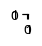

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

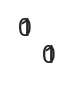

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


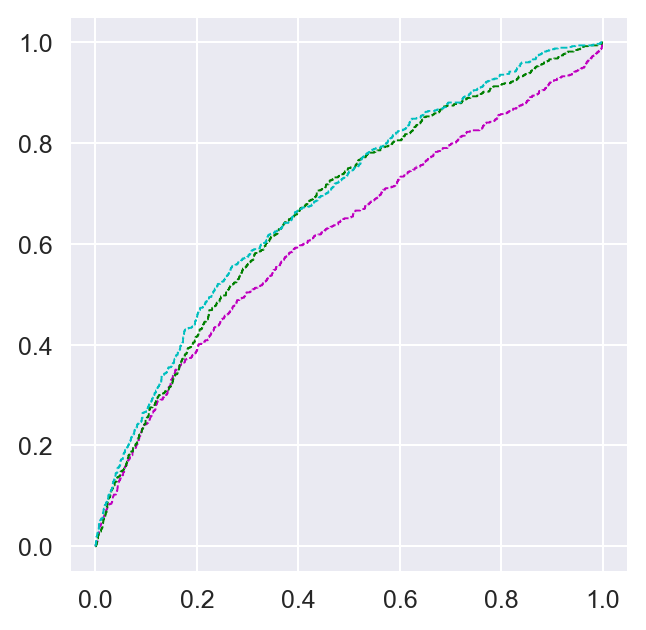

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

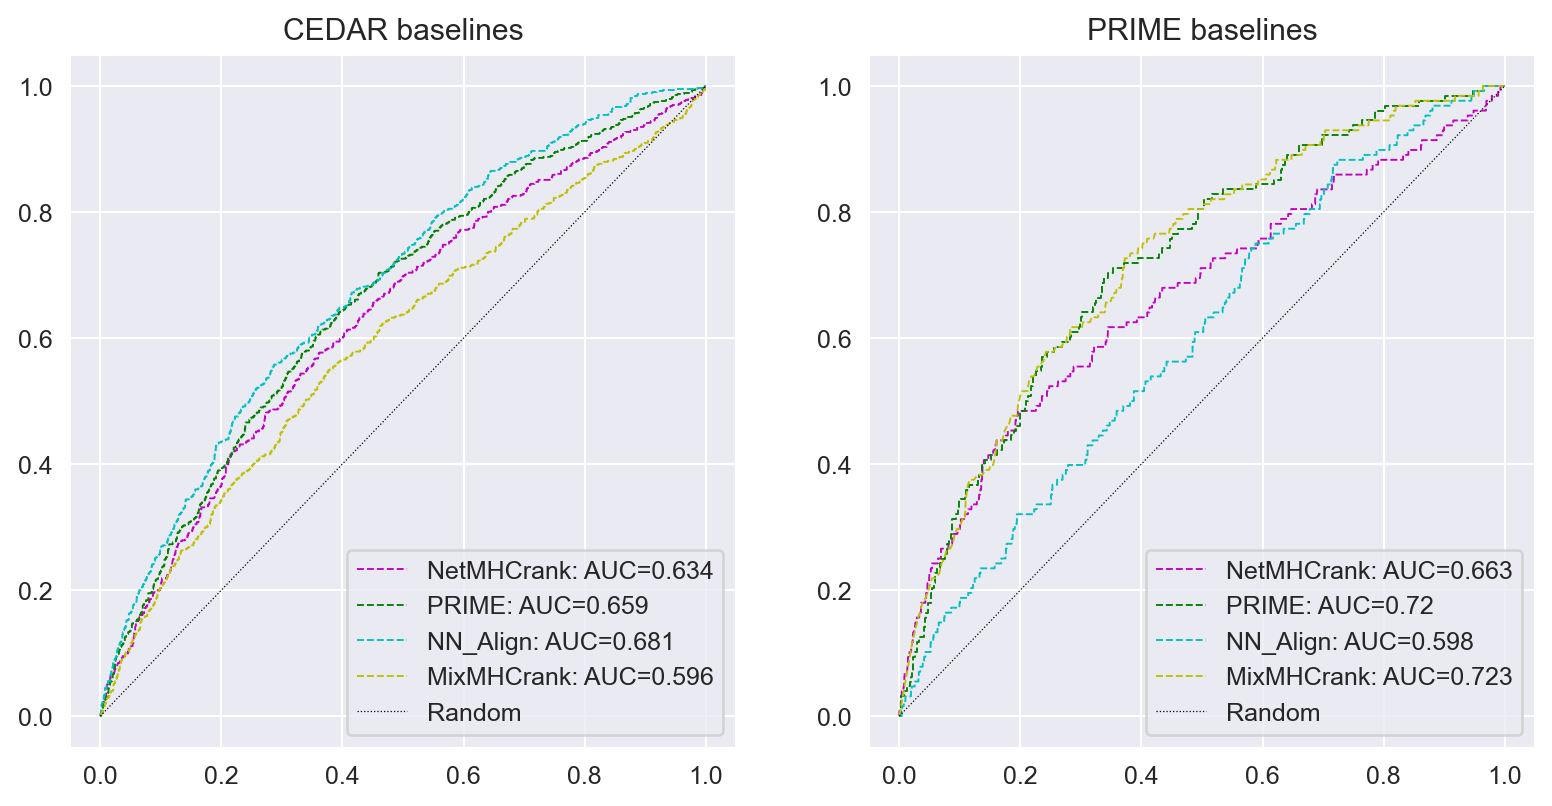

In [16]:
f,a = plt.subplots(1,2, figsize=(10.5,5))
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
a[0].set_title('CEDAR baselines')
a[1].set_title('PRIME baselines')
a[0].legend()
a[1].legend()

## baselines

# Per HLA model

## Save data

In [644]:
display(cedar_related.groupby('HLA').agg(count=('Peptide', 'count')).sort_values('count', ascending=False).head(7))
display(prime_related.groupby('HLA').agg(count=('Peptide', 'count')).sort_values('count', ascending=False).head(7))
common_top_hlas = sorted(cedar_related.groupby('HLA').agg(count=('Peptide', 'count')).sort_values('count', ascending=False).head(7).index.join(prime_related.groupby('HLA').agg(count=('Peptide', 'count')).sort_values('count', ascending=False).head(7).index,
                                                                                                                                        how = 'inner'))
common_top_hlas

,count
HLA,
HLA-A0201,1168
HLA-B0702,307
HLA-A2402,294
HLA-A1101,252
HLA-A0301,159
HLA-B1501,149
HLA-B3501,109


,count
HLA,
HLA-A0201,838
HLA-A1101,515
HLA-B1501,218
HLA-B0702,209
HLA-B3501,166
HLA-A0101,163
HLA-A2402,135


['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']

In [650]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
# take common HLAs in top 5 : ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']
# Do 10fold nested
for hla in ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']:
    print(f"{hla} CEDAR: pos={len(cedar_related.query('HLA==@hla and agg_label==1'))}, neg={len(cedar_related.query('HLA==@hla and agg_label==0'))}")
    print(f"{hla} PRIME: pos={len(prime_related.query('HLA==@hla and agg_label==1'))}, neg={len(prime_related.query('HLA==@hla and agg_label==0'))}")
    supertype = hla[4:7]
    print(cedar_related.query('HLA.str.contains(@supertype)').HLA.unique())

HLA-A0201 CEDAR: pos=311, neg=857
HLA-A0201 PRIME: pos=36, neg=802
['HLA-A0201' 'HLA-A0206' 'HLA-A0202' 'HLA-A0205' 'HLA-A0203' 'HLA-A0224'
 'HLA-A0211' 'HLA-A0210']
HLA-A1101 CEDAR: pos=30, neg=222
HLA-A1101 PRIME: pos=13, neg=502
['HLA-A1101' 'HLA-A1102']
HLA-A2402 CEDAR: pos=28, neg=266
HLA-A2402 PRIME: pos=6, neg=129
['HLA-A2402']
HLA-B0702 CEDAR: pos=21, neg=286
HLA-B0702 PRIME: pos=5, neg=204
['HLA-B0702']
HLA-B1501 CEDAR: pos=17, neg=132
HLA-B1501 PRIME: pos=5, neg=213
['HLA-B1501']
HLA-B3501 CEDAR: pos=15, neg=94
HLA-B3501 PRIME: pos=10, neg=156
['HLA-B3501' 'HLA-B3503']


In [687]:
skf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
train_dataset = prime_related.query('HLA=="HLA-B0702"').copy()
for i, (train_idx, test_idx) in enumerate(skf.split(X=train_dataset['Peptide'].values, 
                                                    y=train_dataset['agg_label'].values,
                                                    groups=train_dataset['agg_label'].values)):
    print(i, test_idx, len(test_idx))
    train_dataset.iloc[test_idx, list(train_dataset.columns).index('fold')] = i
# Do weights loops

0 [  2   8  11  23  34  36  38  50  54  56  57  58  64  69  75  76  82  85
  86 103 104 109 111 115 122 126 127 129 130 139 141 153 154 163 176 177
 180 181 183 185 192 205] 42
1 [  6  12  22  30  37  47  48  53  63  65  66  67  79  87  88  89  92  97
  98 101 107 116 123 125 128 133 134 137 144 146 147 148 151 156 166 169
 178 179 193 194 195 206] 42
2 [  0   4  14  16  18  27  28  29  32  35  40  41  42  44  45  55  61  62
  71  77  83  90  96  99 110 117 121 124 131 136 150 152 158 161 162 167
 171 172 173 175 204 208] 42
3 [  3   7  19  21  25  26  33  43  46  49  51  52  60  72  73  81  91  93
  95 102 108 114 118 120 132 140 142 145 149 160 164 165 174 182 184 187
 189 190 191 200 201 203] 42
4 [  1   5   9  10  13  15  17  20  24  31  39  59  68  70  74  78  80  84
  94 100 105 106 112 113 119 135 138 143 155 157 159 168 170 186 188 196
 197 198 199 202 207] 41


In [28]:
top_hlas = ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']

## results

In [17]:
df_hla = pd.read_csv('../output/221212_HLA_specific_model/total_df.csv')

In [18]:
middle = len(df_hla)//2
df_hla.loc[:middle-1, 'trainset']='CEDAR'
df_hla.loc[middle:, 'trainset']='PRIME'

### gb_agg checks

In [25]:
pd.set_option('display.max_rows', 200)
gb_agg_cedar = df_hla.query('evalset=="CEDAR"').groupby(['hla', 'weight', 'trainset']).agg(mean_auc_cedar = ('auc', 'mean'),
                                                                                           max_auc_cedar = ('auc', 'max'),
                                                                                           min_auc_cedar = ('auc', 'min'),
                                                                                           mean_auc01_cedar = ('auc_01', 'mean'),
                                                                                           mean_f1_cedar = ('f1', 'mean'))

gb_agg_prime = df_hla.query('evalset=="PRIME"').groupby(['hla', 'weight', 'trainset']).agg(mean_auc_prime = ('auc', 'mean'),
                                                                                           max_auc_prime = ('auc', 'max'),
                                                                                           min_auc_prime = ('auc', 'min'),
                                                                                           mean_auc01_prime = ('auc_01', 'mean'),
                                                                                           mean_f1_prime = ('f1', 'mean'))
gb_agg = pd.merge(gb_agg_cedar, gb_agg_prime, left_index=True, right_index=True)
# Re arrange cols
mean_auc_cols = ['mean_auc_cedar', 'mean_auc_prime', 'mean_auc01_cedar', 'mean_auc01_prime']
gb_agg = gb_agg[mean_auc_cols+list(gb_agg.columns.difference(mean_auc_cols))] 

In [26]:
gb_agg

mean_auc_cedar  mean_auc_prime  \
hla       weight           trainset                                   
HLA-A0201 Inverted KL      CEDAR           0.637507        0.677792   
                           PRIME           0.585489        0.653379   
          Inverted Mask    CEDAR           0.636226        0.691818   
                           PRIME           0.596263        0.655689   
          Inverted Shannon CEDAR           0.637785        0.678534   
                           PRIME           0.585076        0.646611   
          KL               CEDAR           0.643052        0.696258   
                           PRIME           0.595306        0.645561   
          Mask             CEDAR           0.644924        0.702083   
                           PRIME           0.619435        0.683079   
          None             CEDAR           0.645088        0.690217   
                           PRIME           0.595761        0.659584   
          Shannon          CEDAR           0.643219        0.696913   
                           PRIME           0.595259        0.642039   
HLA-A1101 Inverted KL      CEDAR           0.601673        0.598800   
                           PRIME           0.614102        0.605617   
          Inverted Mask    CEDAR           0.633168        0.647699   
                           PRIME           0.636729        0.666900   
          Inverted Shannon CEDAR           0.597541        0.600027   
                           PRIME           0.615412        0.608906   
          KL               CEDAR           0.622433        0.633564   
                           PRIME           0.605631        0.655053   
          Mask             CEDAR           0.621300        0.628602   
                           PRIME           0.625609        0.681658   
          None             CEDAR           0.629558        0.641023   
                           PRIME           0.634458        0.668852   
          Shannon          CEDAR           0.622905        0.636421   
                           PRIME           0.606510        0.656930   
HLA-A2402 Inverted KL      CEDAR           0.529418        0.546210   
                           PRIME           0.471611        0.427671   
          Inverted Mask    CEDAR           0.572936        0.609803   
                           PRIME           0.474647        0.449439   
          Inverted Shannon CEDAR           0.527770        0.548373   
                           PRIME           0.473547        0.429009   
          KL               CEDAR           0.575526        0.642389   
                           PRIME           0.509541        0.480893   
          Mask             CEDAR           0.589704        0.664692   
                           PRIME           0.529740        0.502776   
          None             CEDAR           0.588888        0.637668   
                           PRIME           0.491077        0.470699   
          Shannon          CEDAR           0.575982        0.643504   
                           PRIME           0.509712        0.482558   
HLA-B0702 Inverted KL      CEDAR           0.609825        0.607743   
                           PRIME           0.570935        0.597865   
          Inverted Mask    CEDAR           0.634318        0.672539   
                           PRIME           0.601013        0.636905   
          Inverted Shannon CEDAR           0.608733        0.605356   
                           PRIME           0.570196        0.596823   
          KL               CEDAR           0.610614        0.656254   
                           PRIME           0.595318        0.652326   
          Mask             CEDAR           0.612849        0.644835   
                           PRIME           0.610966        0.680209   
          None             CEDAR           0.631859        0.681775   
                           PRIME           0.604571        0.664347   
          Shannon          CEDAR           0.610359        0.

In [55]:
def replace_weight(weight):
    if weight == 'None':
        return weight
    
    else:
        if 'Inverted' in weight:
            weight = weight.replace('Inverted', 'IC')
        else:
            weight = '(1-IC) ' + weight
            
        if 'KL' in weight:
            return weight.replace('KL', 'KL/Sh')
        elif 'Shannon' in weight:
            return weight.replace('Shannon', 'KL/Sh')
        elif weight == 'Mask':
            return 'IC ' + weight
        return weight
list(map(replace_weight, df_hla.weight.unique()))

['IC Mask',
 'IC KL/Sh',
 'IC KL/Sh',
 '(1-IC) Mask',
 '(1-IC) KL/Sh',
 'None',
 '(1-IC) KL/Sh']

In [77]:
tmp_df = df_hla.query('hla == "HLA-A0201" and trainset=="CEDAR"')
tmp = pd.melt(tmp_df, id_vars = ['weight', 'hla', 'evalset', 'trainset'], value_vars= ['auc', 'auc_01'])
tmp['x'] = tmp.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis = 1)
sns.boxplot(data=tmp, x='x', y = 'value', hue='weight')

In [80]:
tmp.head(3)

,weight,hla,evalset,trainset,variable,value,x
0,Inverted Mask,HLA-A0201,CEDAR,CEDAR,auc,0.640189,CEDAR auc
1,Inverted Mask,HLA-A0201,CEDAR,CEDAR,auc,0.640385,CEDAR auc
2,Inverted Mask,HLA-A0201,CEDAR,CEDAR,auc,0.645415,CEDAR auc


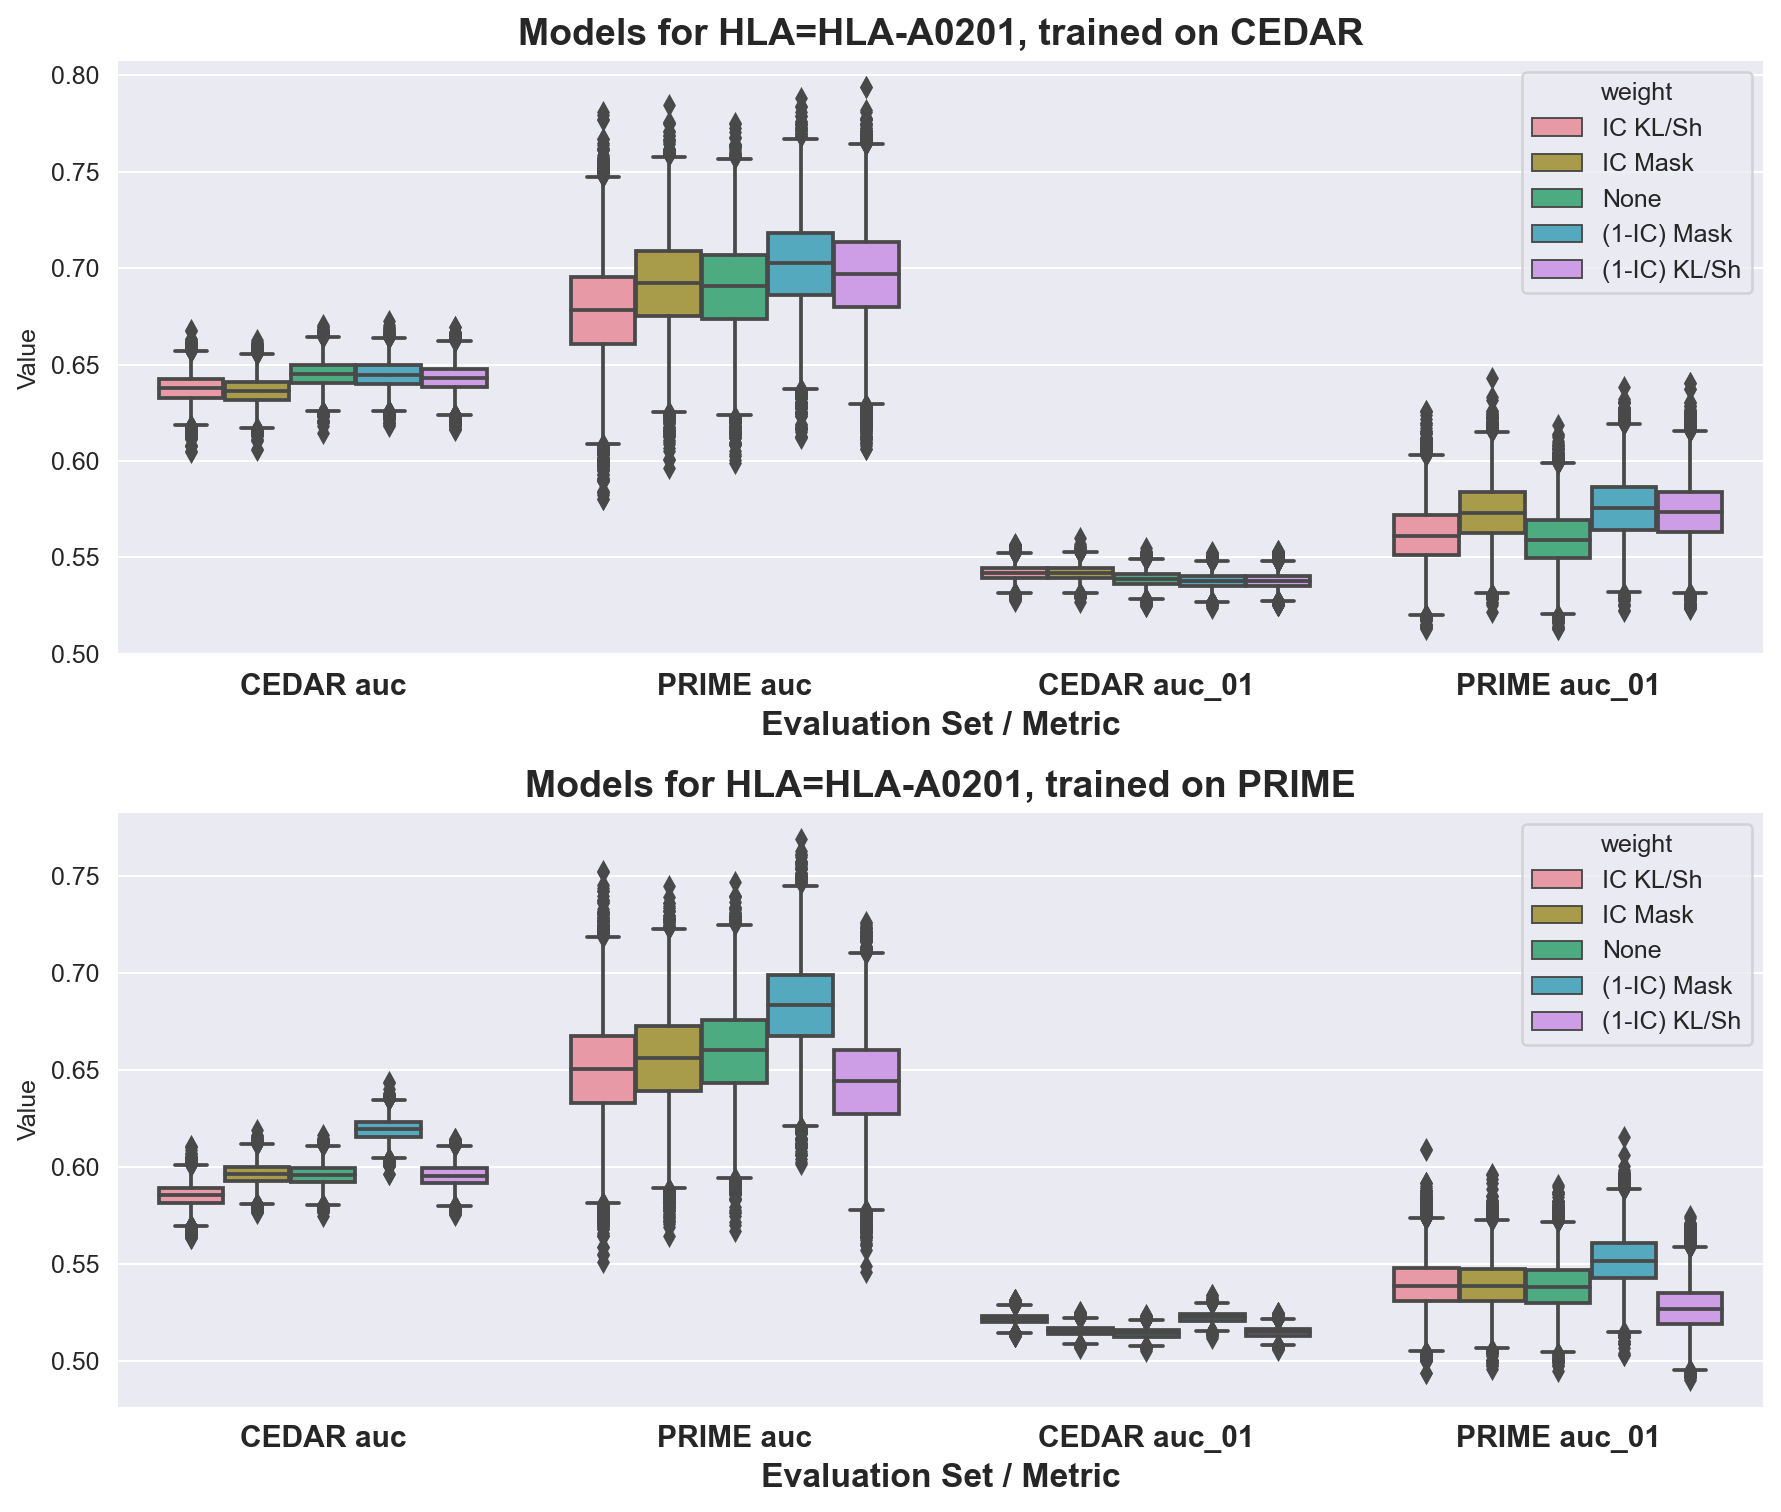

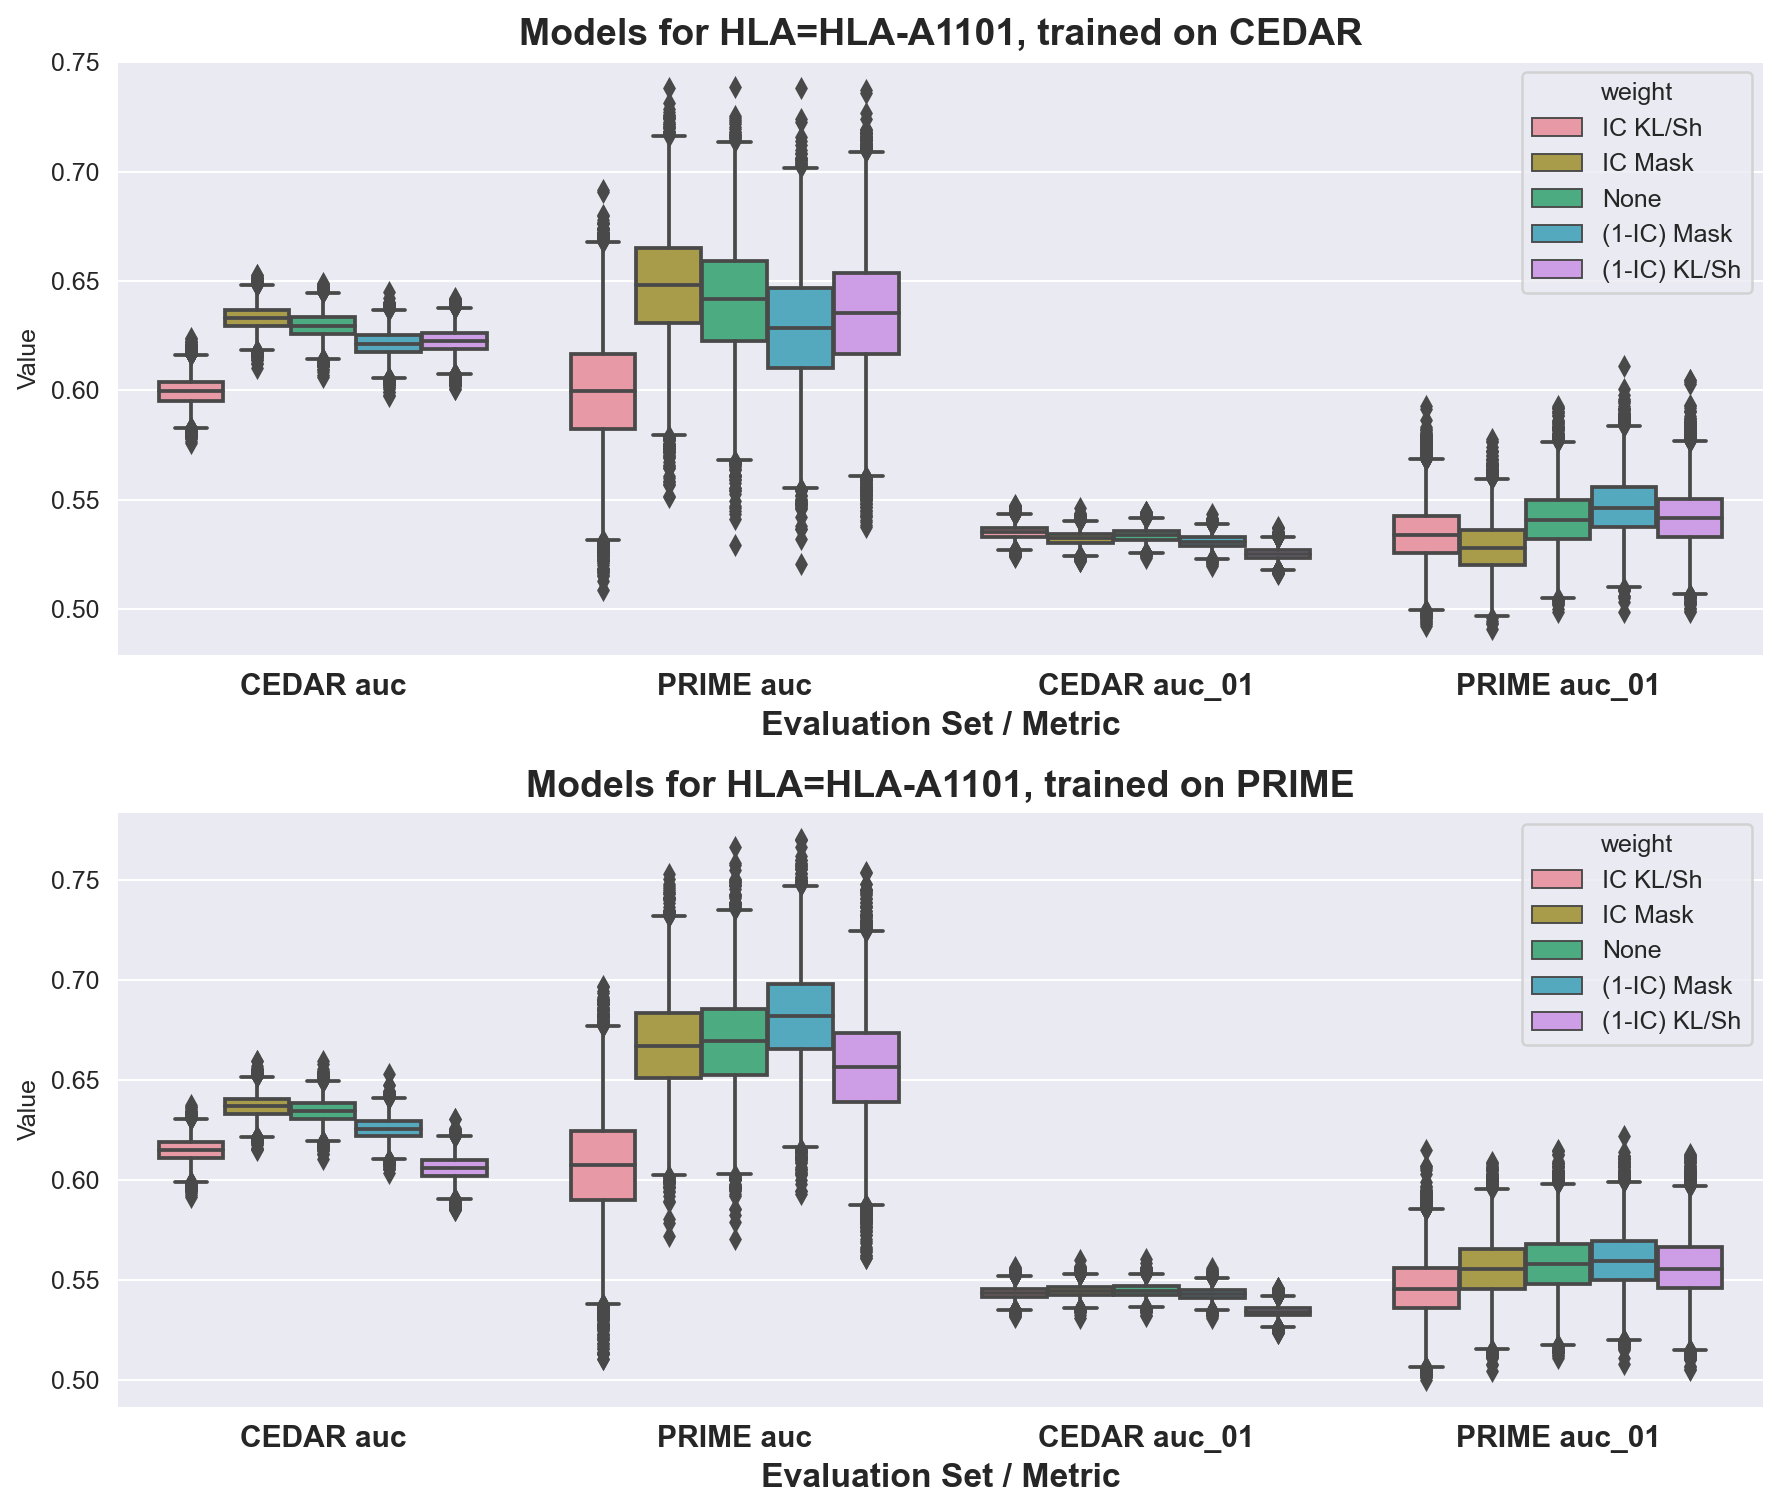

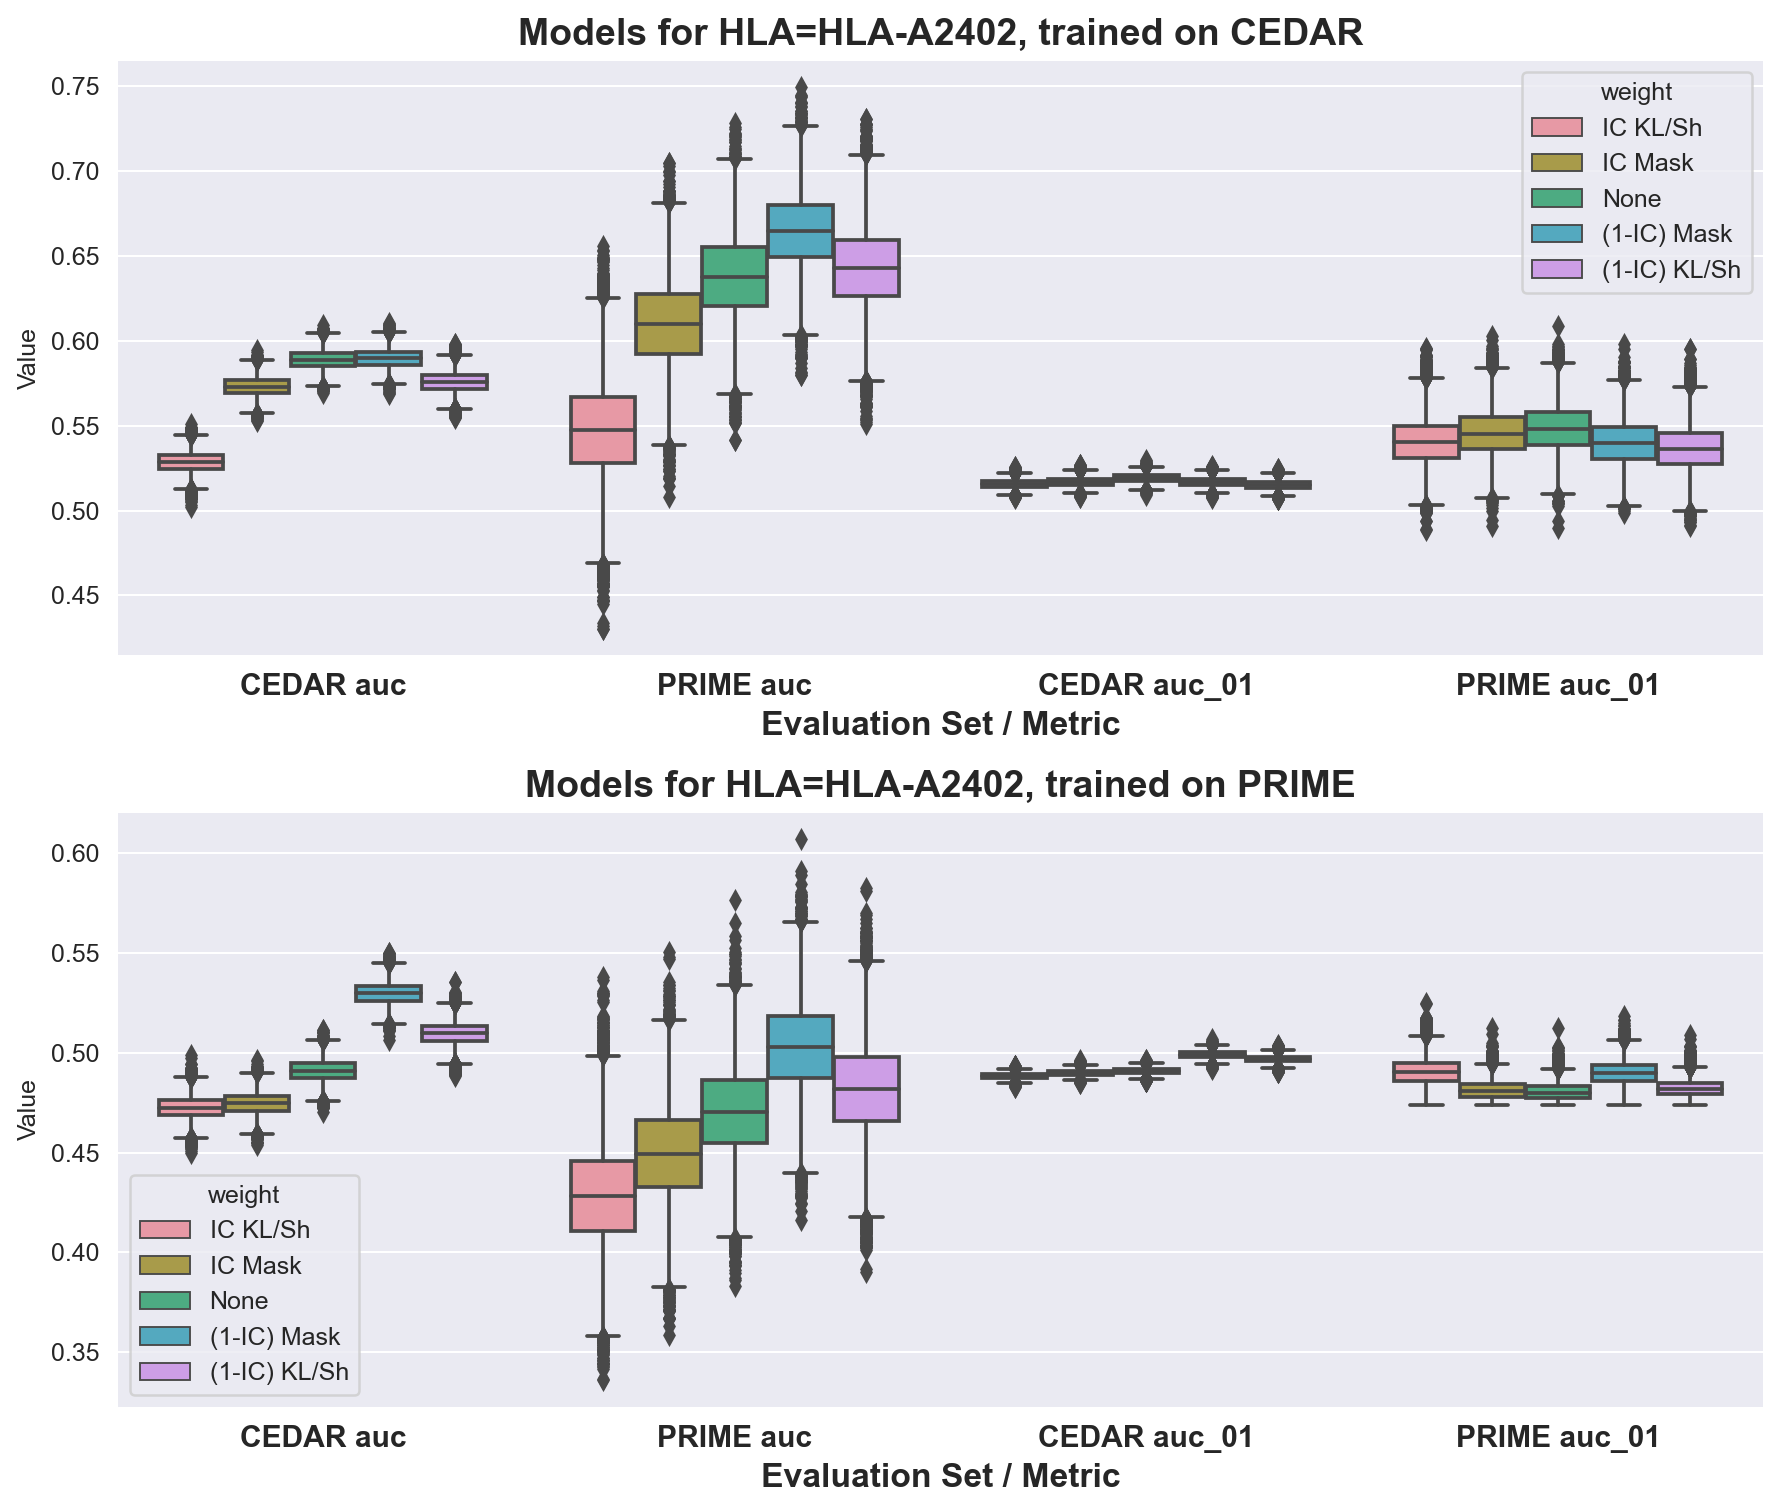

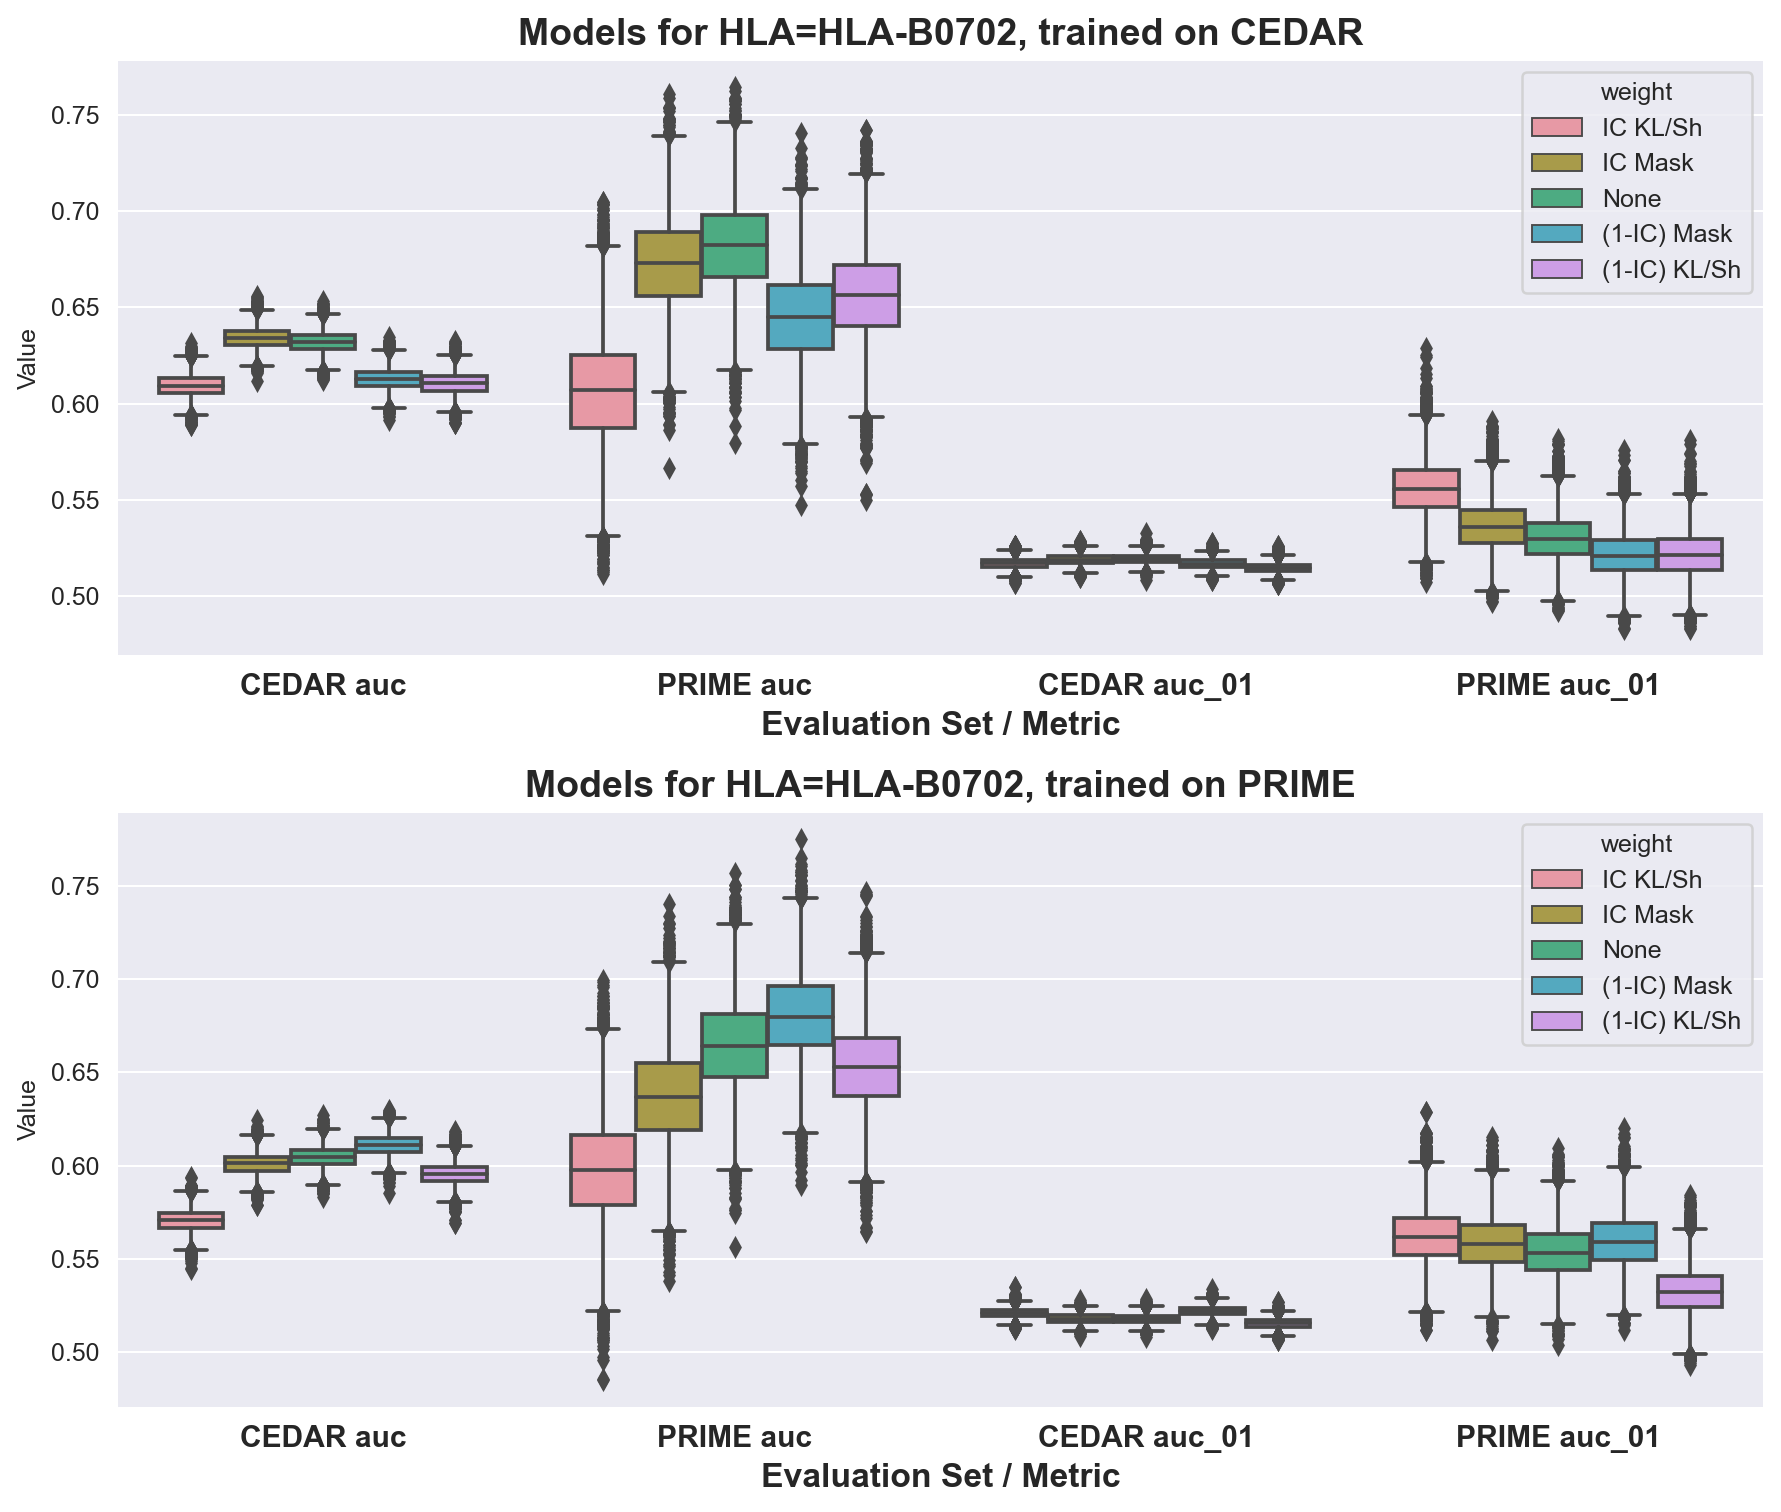

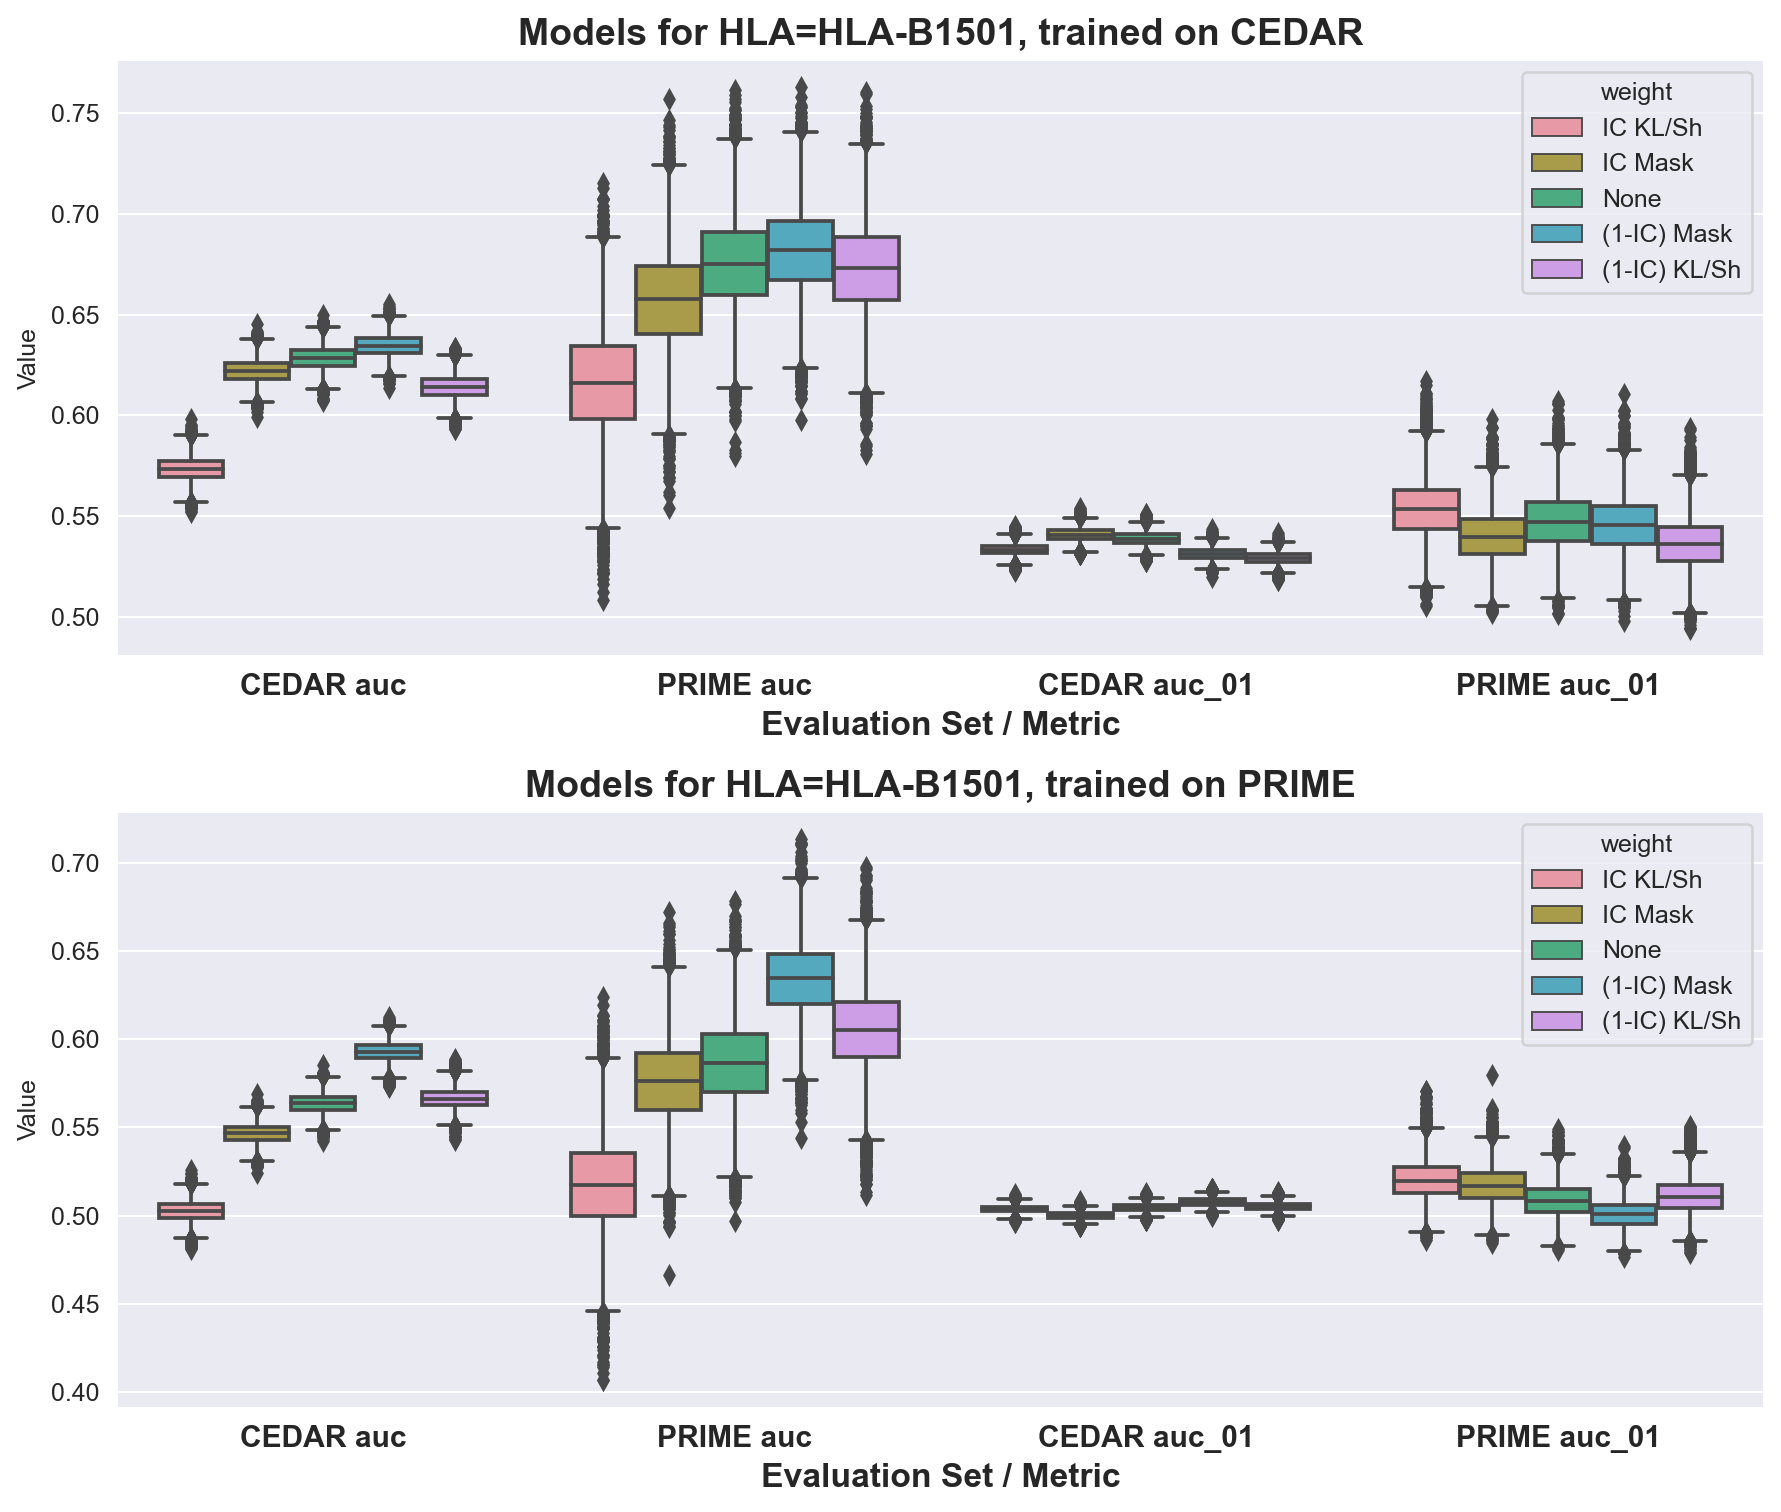

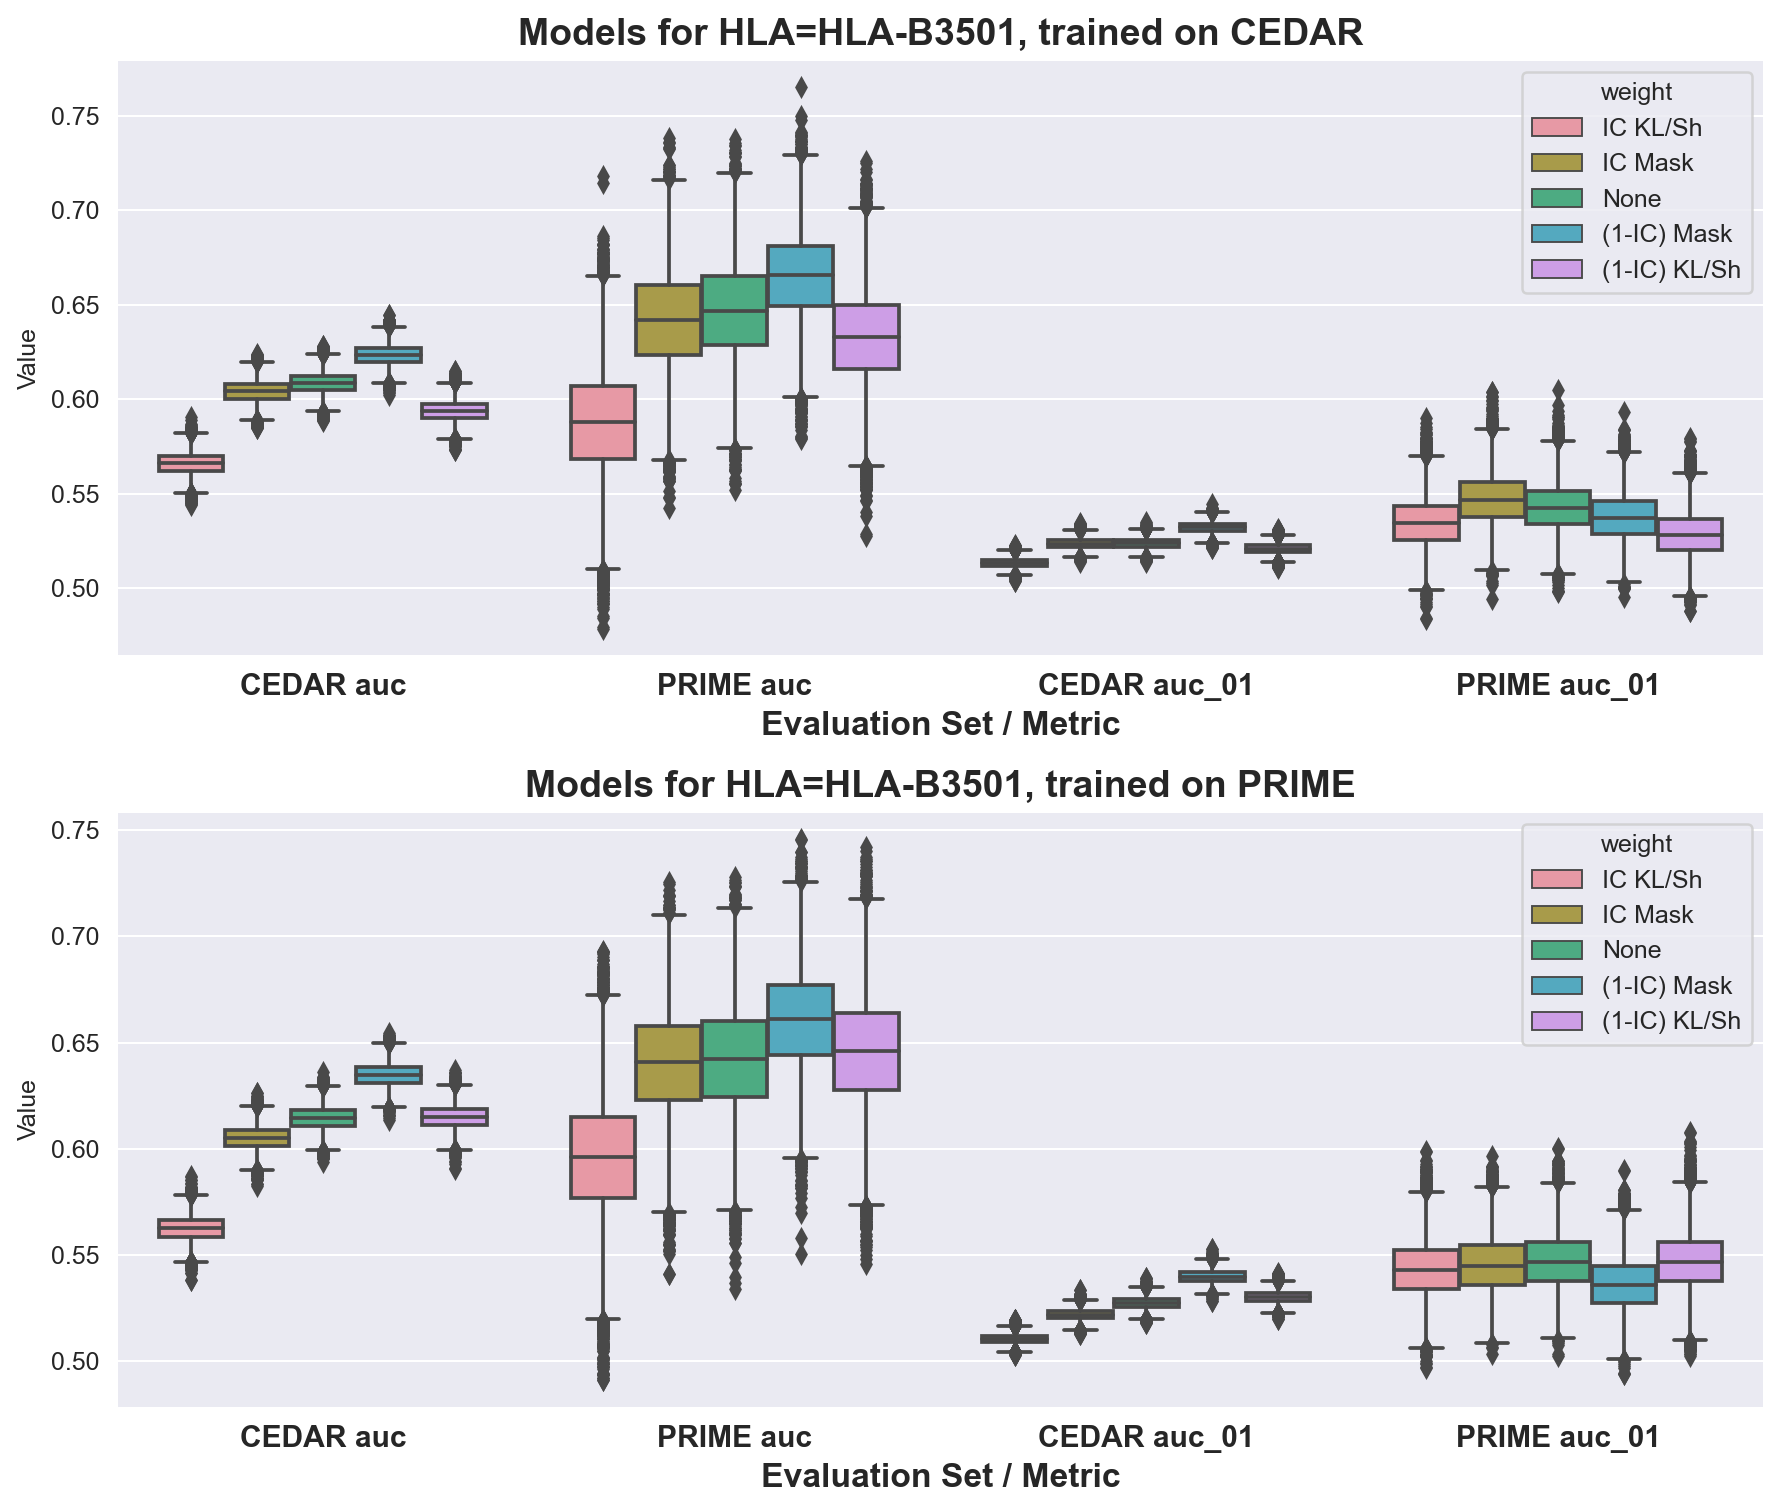

In [87]:
from sklearn.model_selection import StratifiedKFold
weight_order = ['IC KL/Sh', 'IC Mask', 'None', '(1-IC) Mask', '(1-IC) KL/Sh']
# For each HLA, do a subplot for each trainset
# Each subplot takes Weight as hue, and Evalset as X
for hla in df_hla.hla.unique():
    # Just getting N per trainsets for a 5fold kcv
    n_pos_cedar = len(cedar_related.query('HLA==@hla and agg_label==1'))//5
    n_neg_cedar = len(cedar_related.query('HLA==@hla and agg_label==0'))//5
    n_pos_prime = len(prime_related.query('HLA==@hla and agg_label==1'))//5
    n_neg_prime = len(prime_related.query('HLA==@hla and agg_label==0'))//5    
    # Plotting for each trainset/subplot
    f,a = plt.subplots(2, 1, figsize=(10,8.5))
    for trainset, axis in zip(['CEDAR', 'PRIME'], a.ravel()):
        tmp_df = pd.melt(df_hla.query('hla==@hla and trainset==@trainset').drop(columns = ['hla', 'trainset']),
                         id_vars = ['weight', 'evalset'], value_vars = ['auc', 'auc_01'])
        tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
        tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
        sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
        plt.setp(axis.collections, alpha=.75)
        axis.set_title(f'Models for HLA={hla}, trained on {trainset}', fontweight = 'semibold', fontsize = 15)
        axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12))
        axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
        axis.set_ylabel('Value')
    f.tight_layout()
    f.savefig(f'../output/hla_analysis/{hla}_models_boxplots.png', bbox_inches = 'tight', dpi = 200)

# Rest HLA models 

## results

In [88]:
df_rest = pd.read_csv('../output/221219_HLA_non_specific/total_df.csv')

In [91]:
middle = len(df_rest)//2
df_rest.loc[:middle-1, 'trainset']='CEDAR'
df_rest.loc[middle:, 'trainset']='PRIME'

In [92]:
df_rest

,auc,prauc,AP,auc_01,f1,accuracy,precision,recall,encoding,weight,hla,evalset,trainset
0,0.689732,0.147855,0.161603,0.599138,0.00000,0.946498,0.0,0.000000,onehot,Inverted Mask,non_top,CEDAR,CEDAR
1,0.538017,0.092988,0.104558,0.559464,0.00000,0.946498,0.0,0.000000,onehot,Inverted Mask,non_top,CEDAR,CEDAR
2,0.610536,0.084621,0.092771,0.561409,0.00000,0.954280,0.0,0.000000,onehot,Inverted Mask,non_top,CEDAR,CEDAR
3,0.639613,0.110261,0.123893,0.570443,0.00000,0.948444,0.0,0.000000,onehot,Inverted Mask,non_top,CEDAR,CEDAR
4,0.606992,0.110707,0.123583,0.586834,0.00000,0.952335,0.0,0.000000,onehot,Inverted Mask,non_top,CEDAR,CEDAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279995,0.648345,0.372247,0.377156,0.534306,0.01005,0.738727,1.0,0.005051,onehot,Shannon,non_top,PRIME,PRIME
279996,0.643835,0.369440,0.374071,0.535677,0.00000,0.740053,0.0,0.000000,onehot,Shannon,non_top,PRIME,PRIME
279997,0.697536,0.483157,0.488757,0.562195,0.00000,0.694960,0.0,0.000000,onehot,Shannon,non_top,PRIME,PRIME
279998,0.661004,0.416120,0.422552,0.550878,0.00000,0.713528,0.0,0.000000,onehot,Shannon,non_top,PRIME,PRIME


### gb_agg checks

In [25]:
pd.set_option('display.max_rows', 200)
gb_agg_cedar = df_hla.query('evalset=="CEDAR"').groupby(['hla', 'weight', 'trainset']).agg(mean_auc_cedar = ('auc', 'mean'),
                                                                                           max_auc_cedar = ('auc', 'max'),
                                                                                           min_auc_cedar = ('auc', 'min'),
                                                                                           mean_auc01_cedar = ('auc_01', 'mean'),
                                                                                           mean_f1_cedar = ('f1', 'mean'))

gb_agg_prime = df_hla.query('evalset=="PRIME"').groupby(['hla', 'weight', 'trainset']).agg(mean_auc_prime = ('auc', 'mean'),
                                                                                           max_auc_prime = ('auc', 'max'),
                                                                                           min_auc_prime = ('auc', 'min'),
                                                                                           mean_auc01_prime = ('auc_01', 'mean'),
                                                                                           mean_f1_prime = ('f1', 'mean'))
gb_agg = pd.merge(gb_agg_cedar, gb_agg_prime, left_index=True, right_index=True)
# Re arrange cols
mean_auc_cols = ['mean_auc_cedar', 'mean_auc_prime', 'mean_auc01_cedar', 'mean_auc01_prime']
gb_agg = gb_agg[mean_auc_cols+list(gb_agg.columns.difference(mean_auc_cols))] 

In [26]:
gb_agg

mean_auc_cedar  mean_auc_prime  \
hla       weight           trainset                                   
HLA-A0201 Inverted KL      CEDAR           0.637507        0.677792   
                           PRIME           0.585489        0.653379   
          Inverted Mask    CEDAR           0.636226        0.691818   
                           PRIME           0.596263        0.655689   
          Inverted Shannon CEDAR           0.637785        0.678534   
                           PRIME           0.585076        0.646611   
          KL               CEDAR           0.643052        0.696258   
                           PRIME           0.595306        0.645561   
          Mask             CEDAR           0.644924        0.702083   
                           PRIME           0.619435        0.683079   
          None             CEDAR           0.645088        0.690217   
                           PRIME           0.595761        0.659584   
          Shannon          CEDAR           0.643219        0.696913   
                           PRIME           0.595259        0.642039   
HLA-A1101 Inverted KL      CEDAR           0.601673        0.598800   
                           PRIME           0.614102        0.605617   
          Inverted Mask    CEDAR           0.633168        0.647699   
                           PRIME           0.636729        0.666900   
          Inverted Shannon CEDAR           0.597541        0.600027   
                           PRIME           0.615412        0.608906   
          KL               CEDAR           0.622433        0.633564   
                           PRIME           0.605631        0.655053   
          Mask             CEDAR           0.621300        0.628602   
                           PRIME           0.625609        0.681658   
          None             CEDAR           0.629558        0.641023   
                           PRIME           0.634458        0.668852   
          Shannon          CEDAR           0.622905        0.636421   
                           PRIME           0.606510        0.656930   
HLA-A2402 Inverted KL      CEDAR           0.529418        0.546210   
                           PRIME           0.471611        0.427671   
          Inverted Mask    CEDAR           0.572936        0.609803   
                           PRIME           0.474647        0.449439   
          Inverted Shannon CEDAR           0.527770        0.548373   
                           PRIME           0.473547        0.429009   
          KL               CEDAR           0.575526        0.642389   
                           PRIME           0.509541        0.480893   
          Mask             CEDAR           0.589704        0.664692   
                           PRIME           0.529740        0.502776   
          None             CEDAR           0.588888        0.637668   
                           PRIME           0.491077        0.470699   
          Shannon          CEDAR           0.575982        0.643504   
                           PRIME           0.509712        0.482558   
HLA-B0702 Inverted KL      CEDAR           0.609825        0.607743   
                           PRIME           0.570935        0.597865   
          Inverted Mask    CEDAR           0.634318        0.672539   
                           PRIME           0.601013        0.636905   
          Inverted Shannon CEDAR           0.608733        0.605356   
                           PRIME           0.570196        0.596823   
          KL               CEDAR           0.610614        0.656254   
                           PRIME           0.595318        0.652326   
          Mask             CEDAR           0.612849        0.644835   
                           PRIME           0.610966        0.680209   
          None             CEDAR           0.631859        0.681775   
                           PRIME           0.604571        0.664347   
          Shannon          CEDAR           0.610359        0.

In [55]:
def replace_weight(weight):
    if weight == 'None':
        return weight
    
    else:
        if 'Inverted' in weight:
            weight = weight.replace('Inverted', 'IC')
        else:
            weight = '(1-IC) ' + weight
            
        if 'KL' in weight:
            return weight.replace('KL', 'KL/Sh')
        elif 'Shannon' in weight:
            return weight.replace('Shannon', 'KL/Sh')
        elif weight == 'Mask':
            return 'IC ' + weight
        return weight
list(map(replace_weight, df_hla.weight.unique()))

['IC Mask',
 'IC KL/Sh',
 'IC KL/Sh',
 '(1-IC) Mask',
 '(1-IC) KL/Sh',
 'None',
 '(1-IC) KL/Sh']

In [93]:
dfx = pd.concat([df_hla, df_rest])


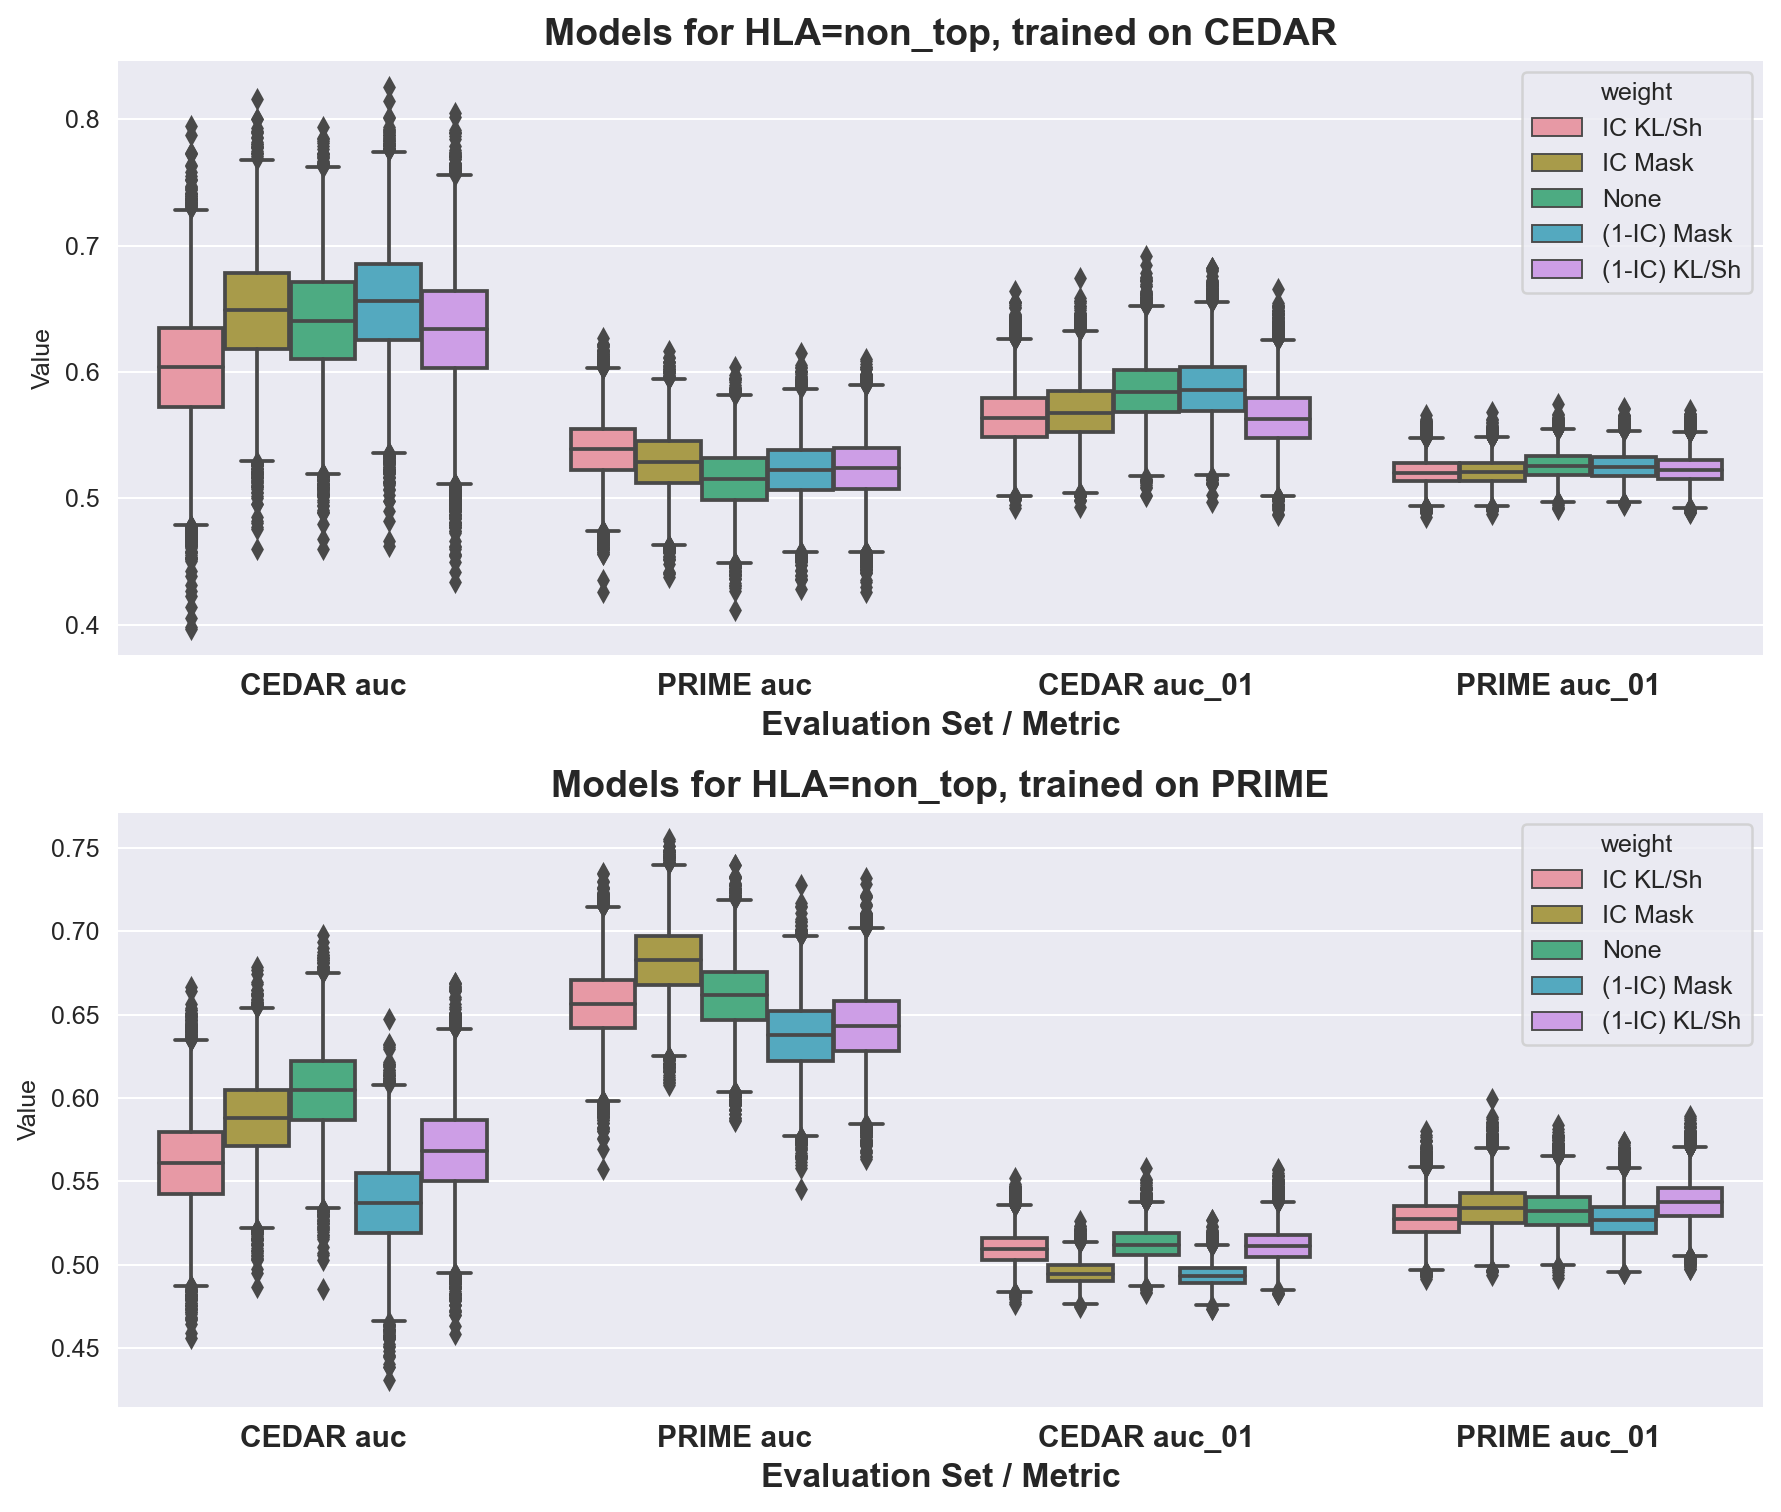

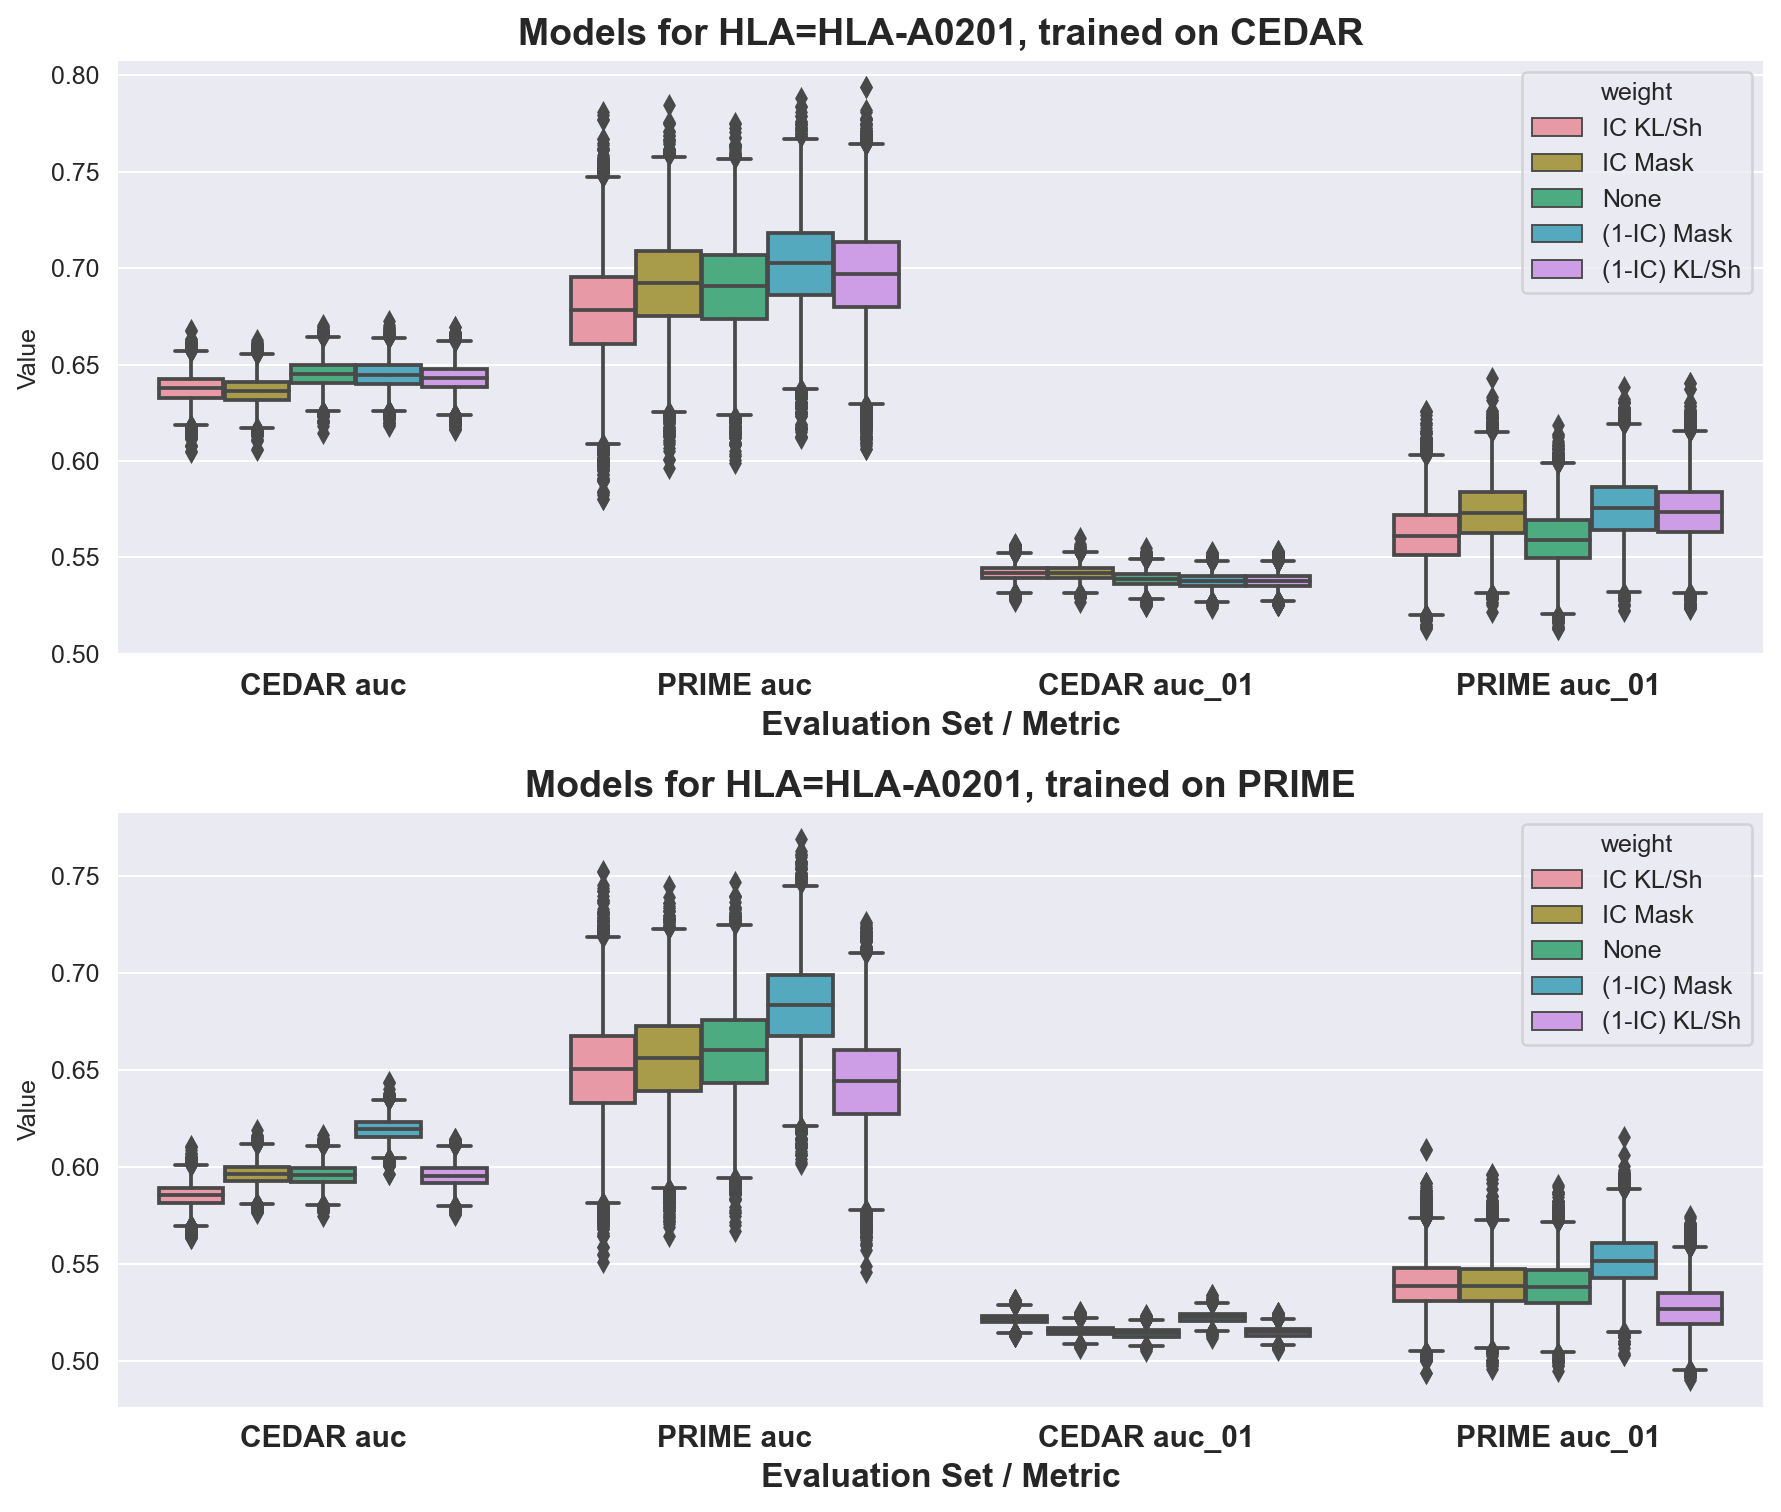

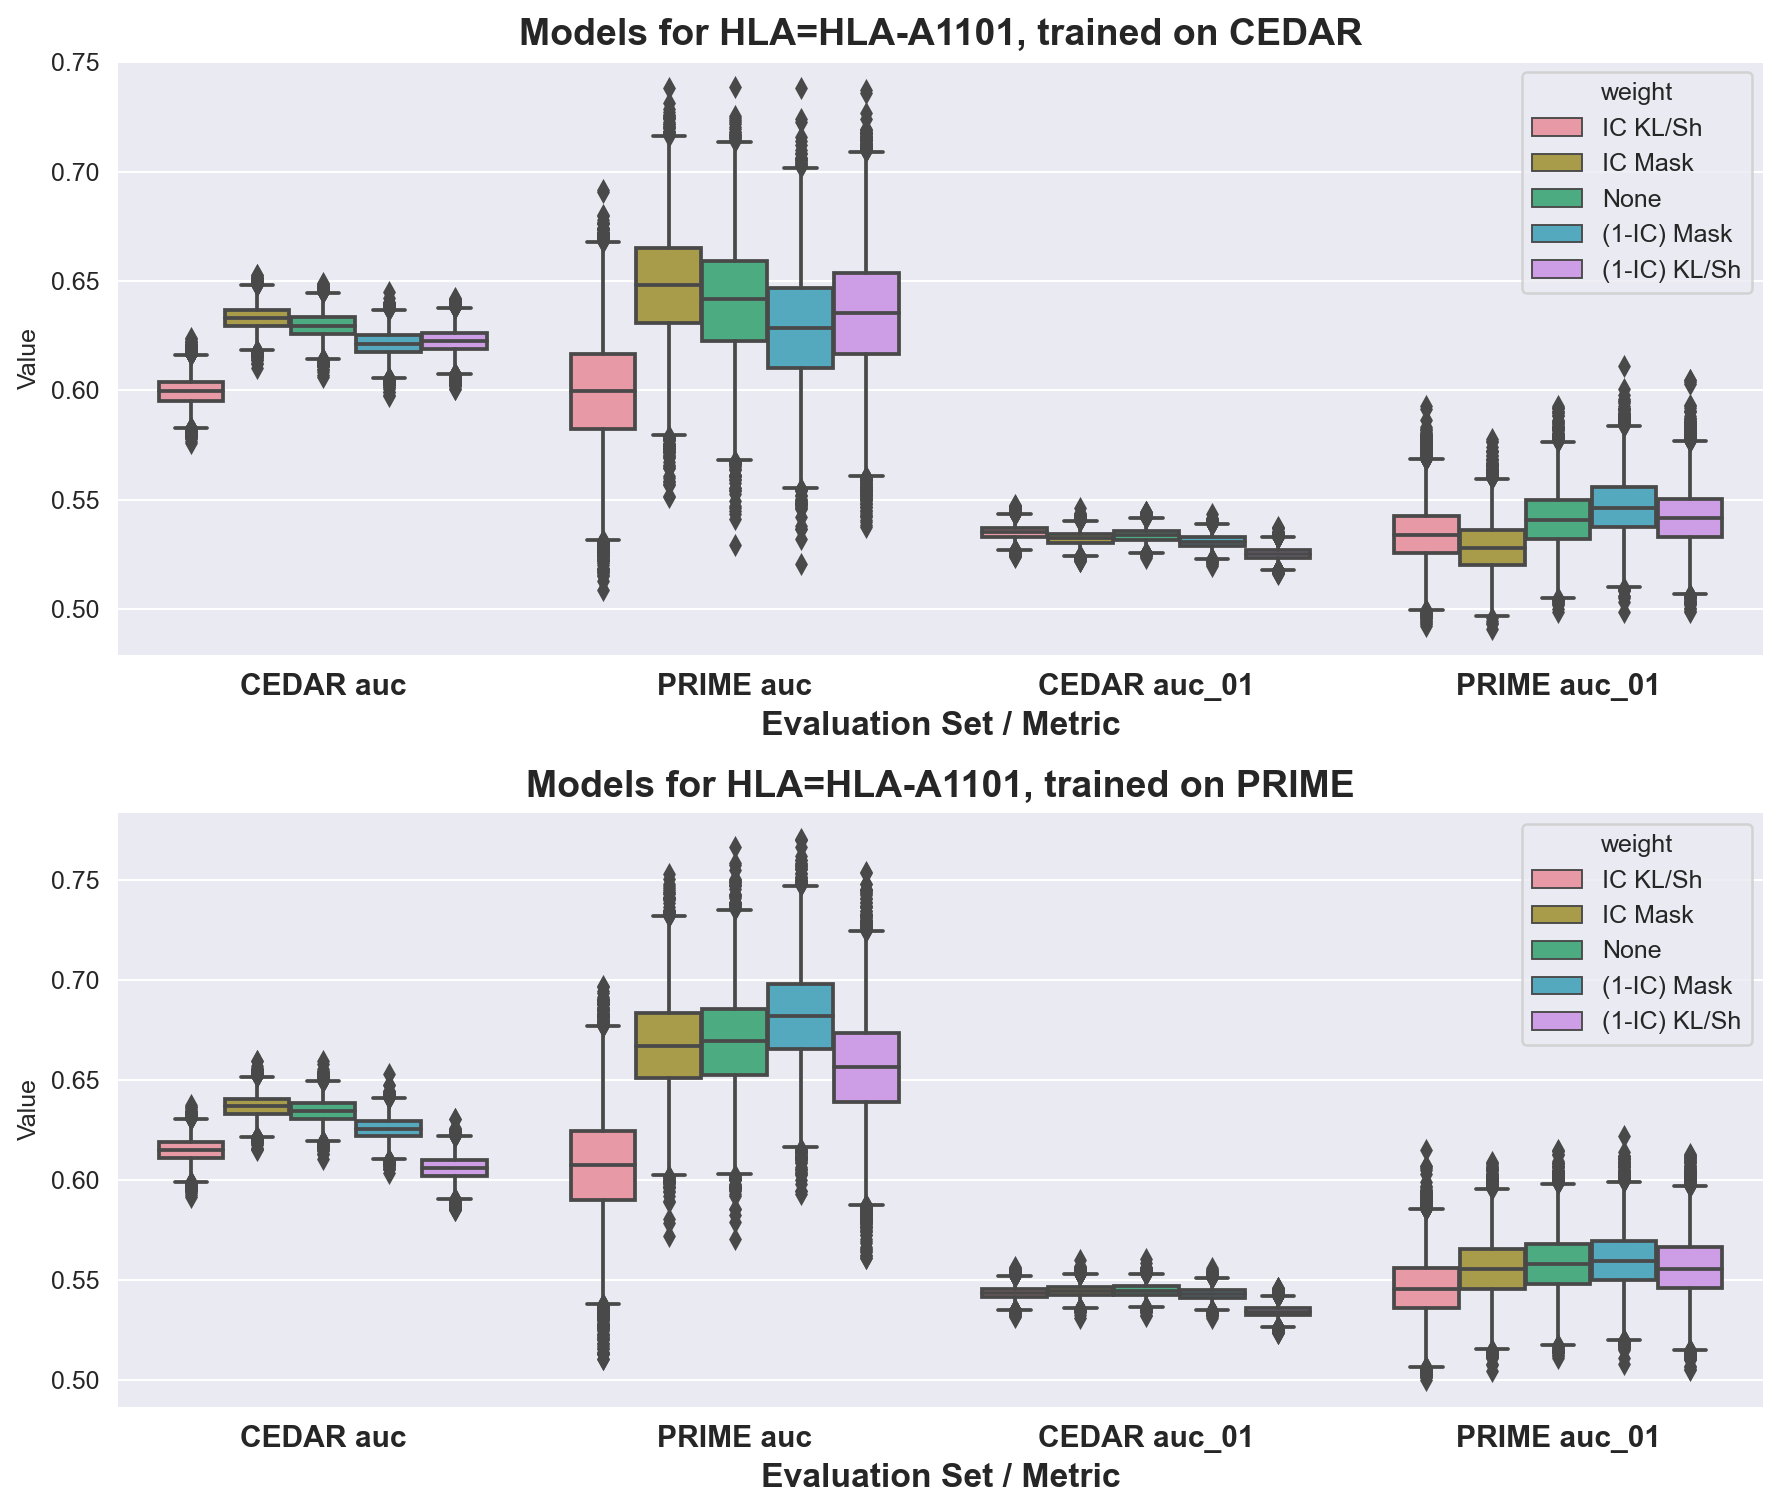

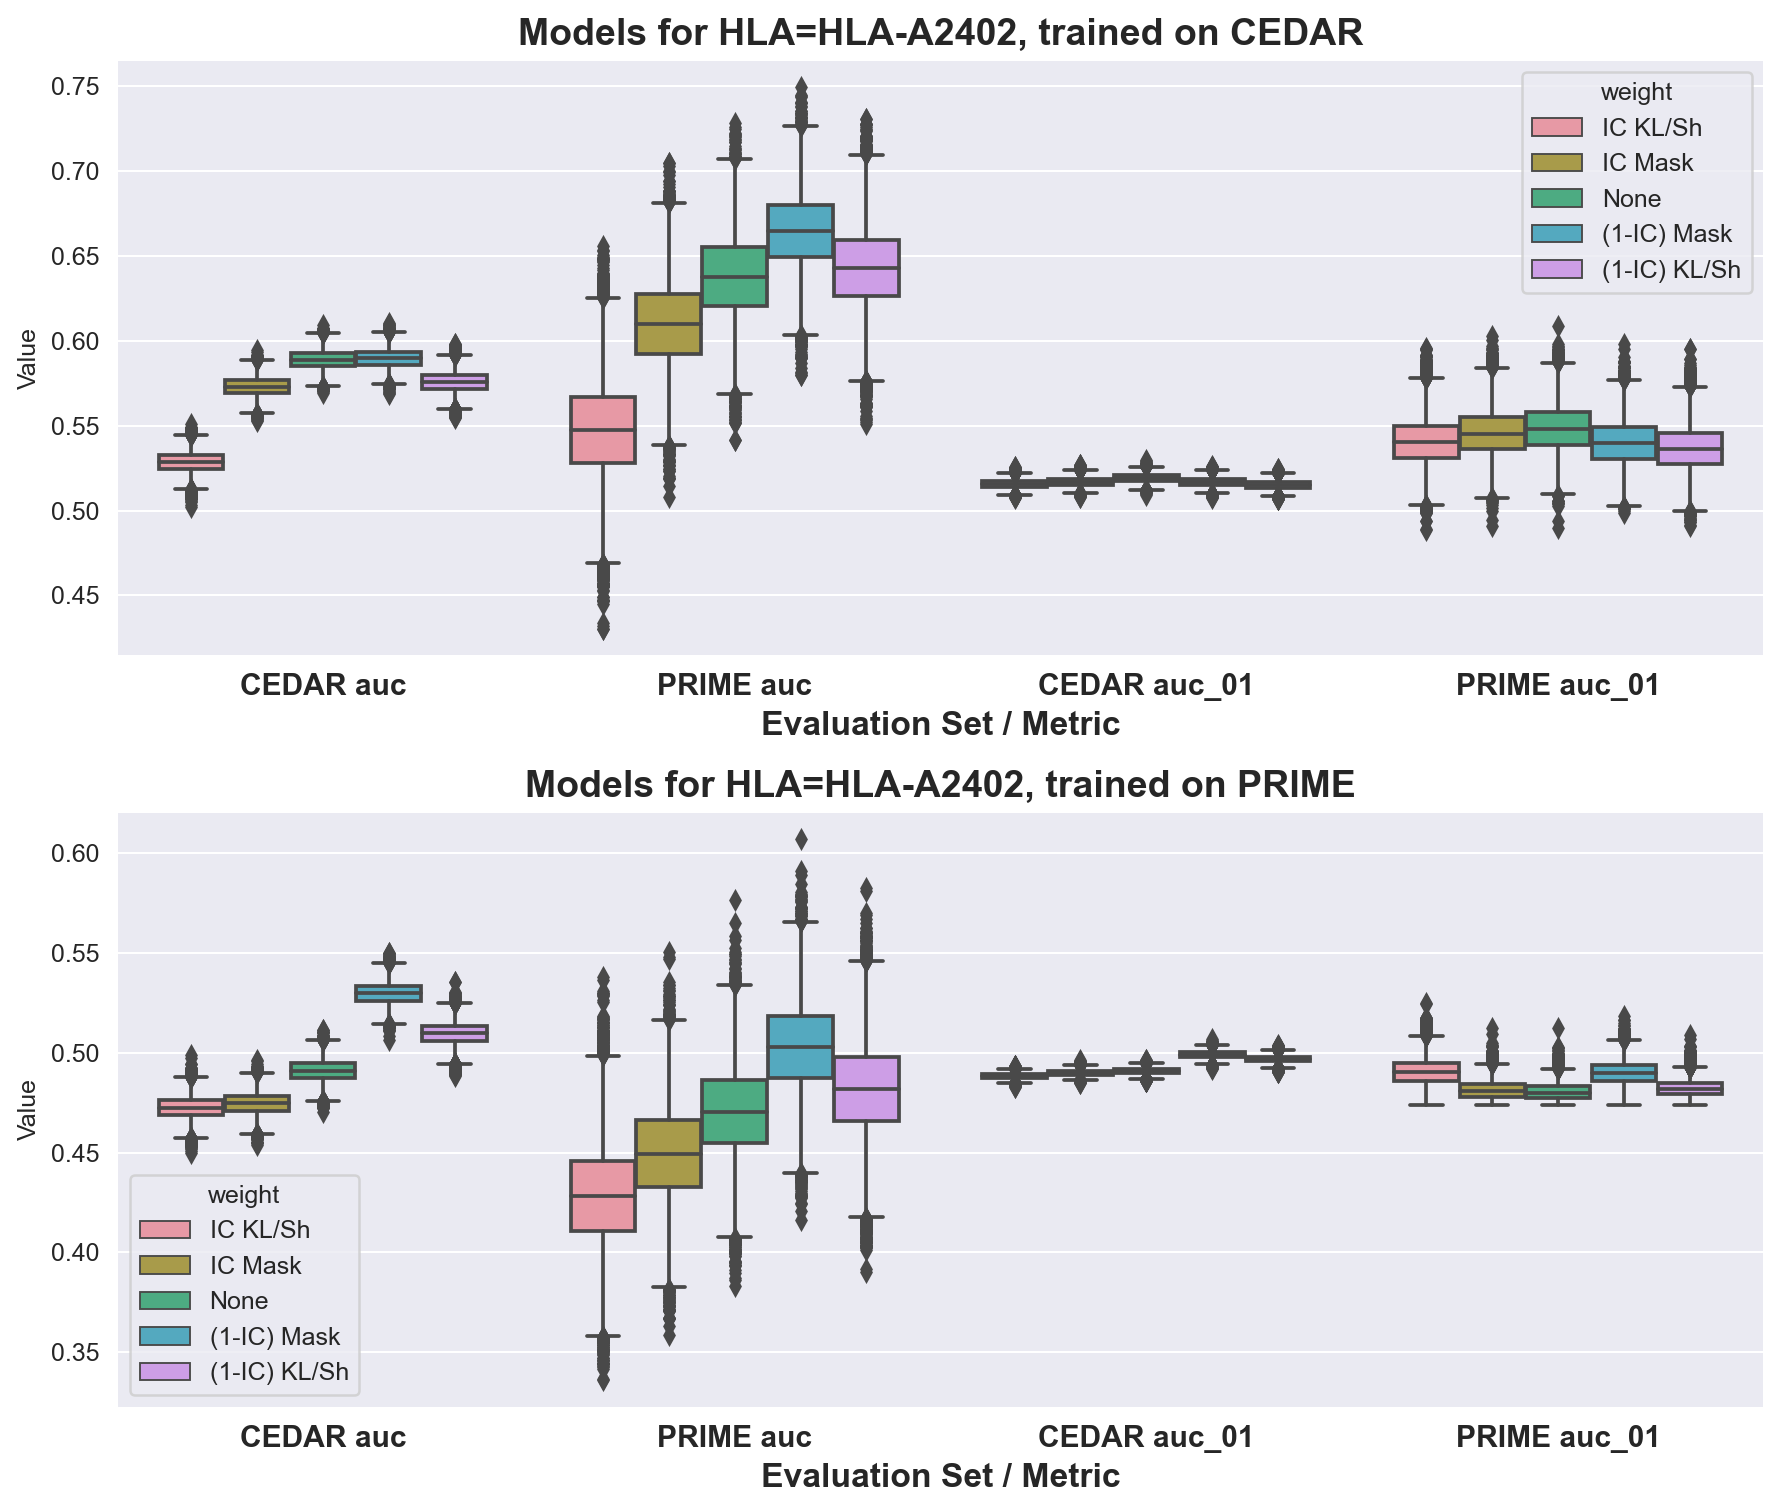

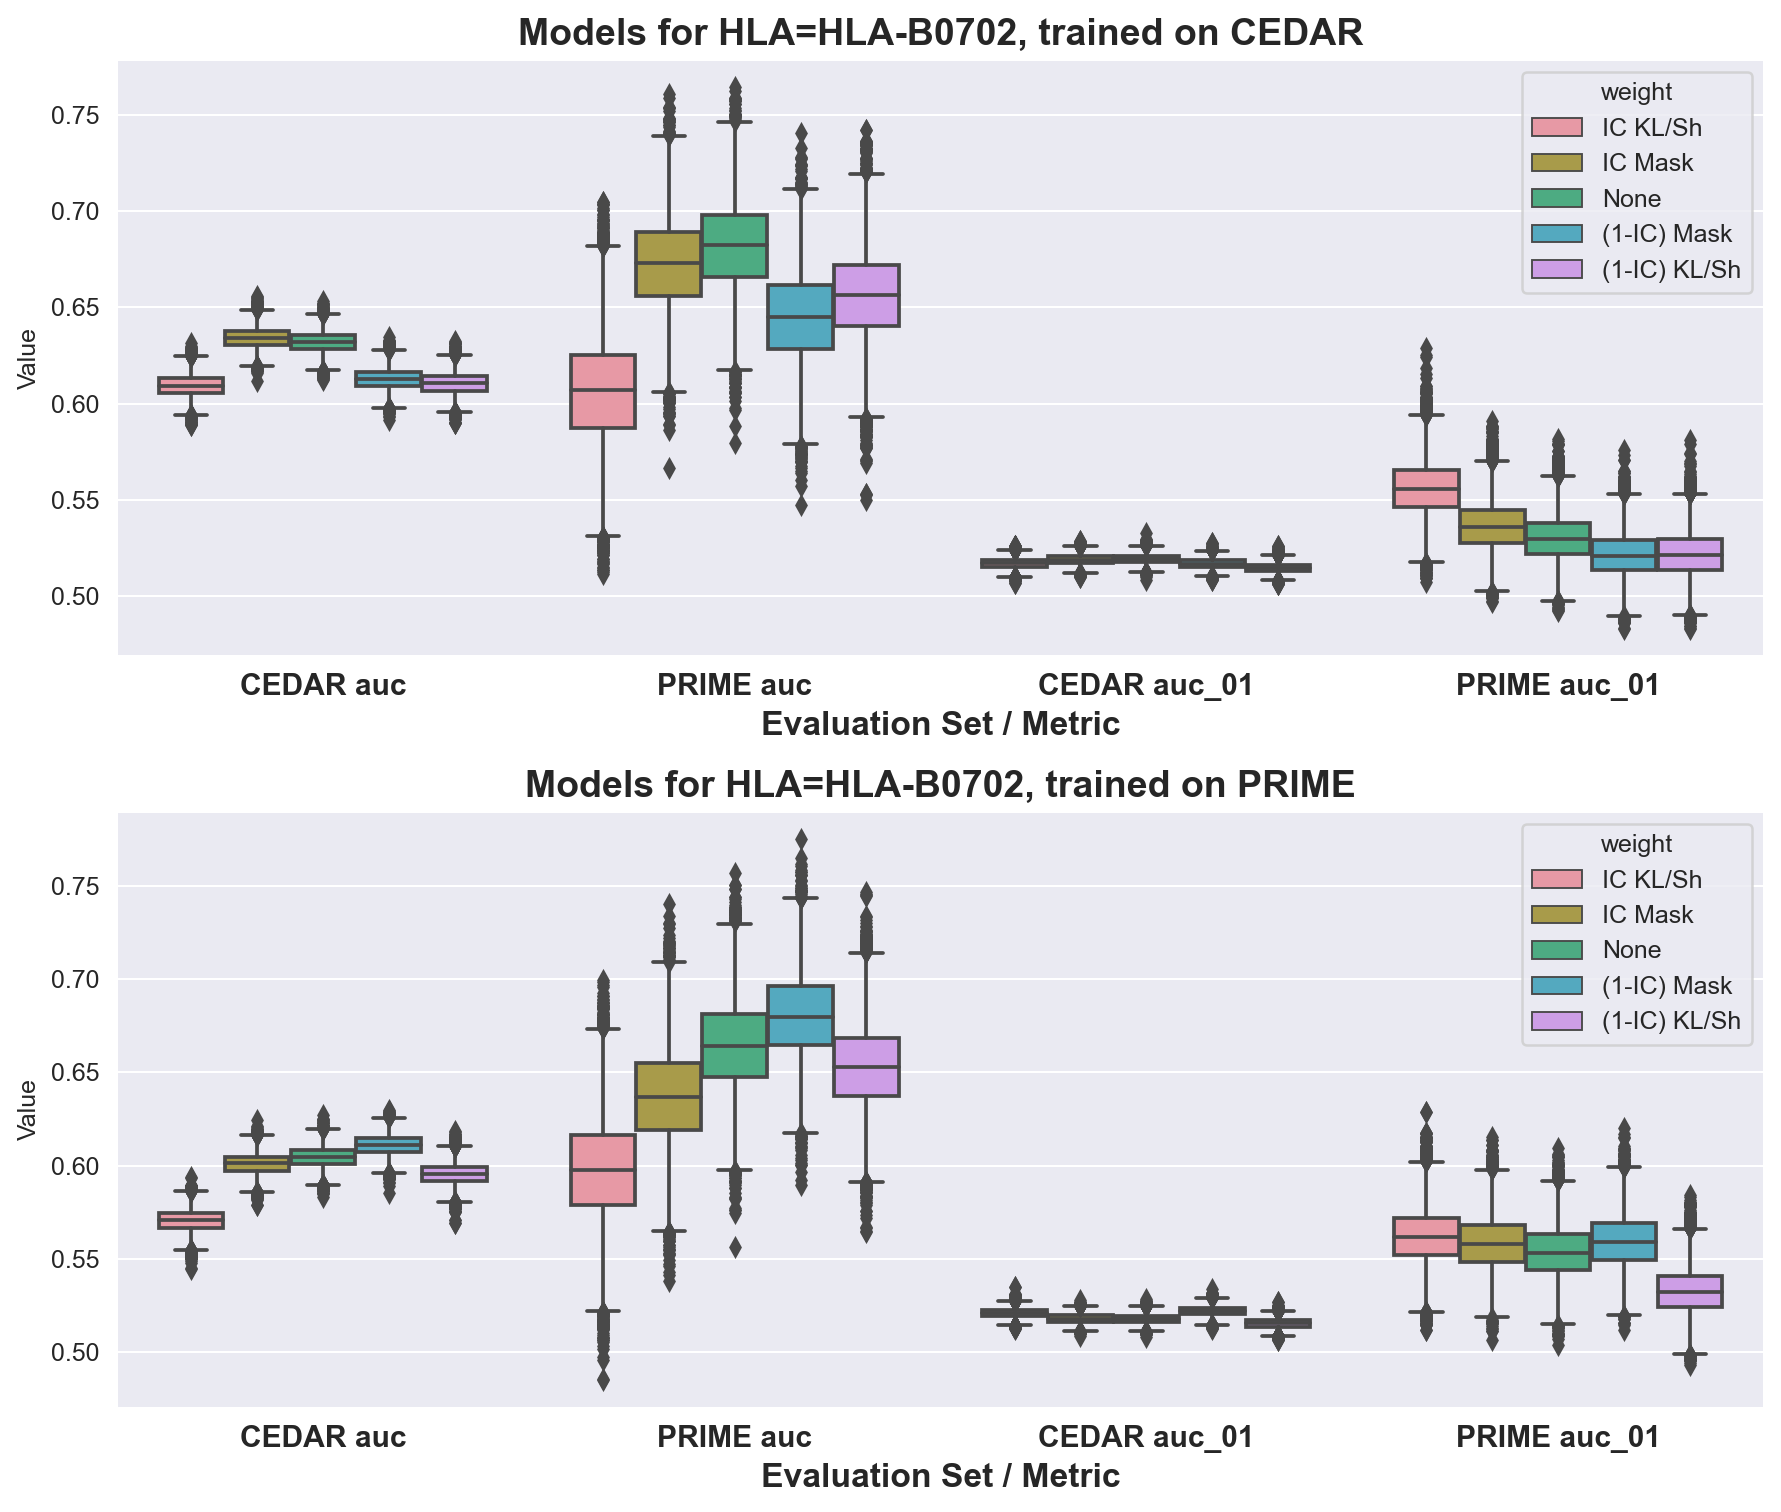

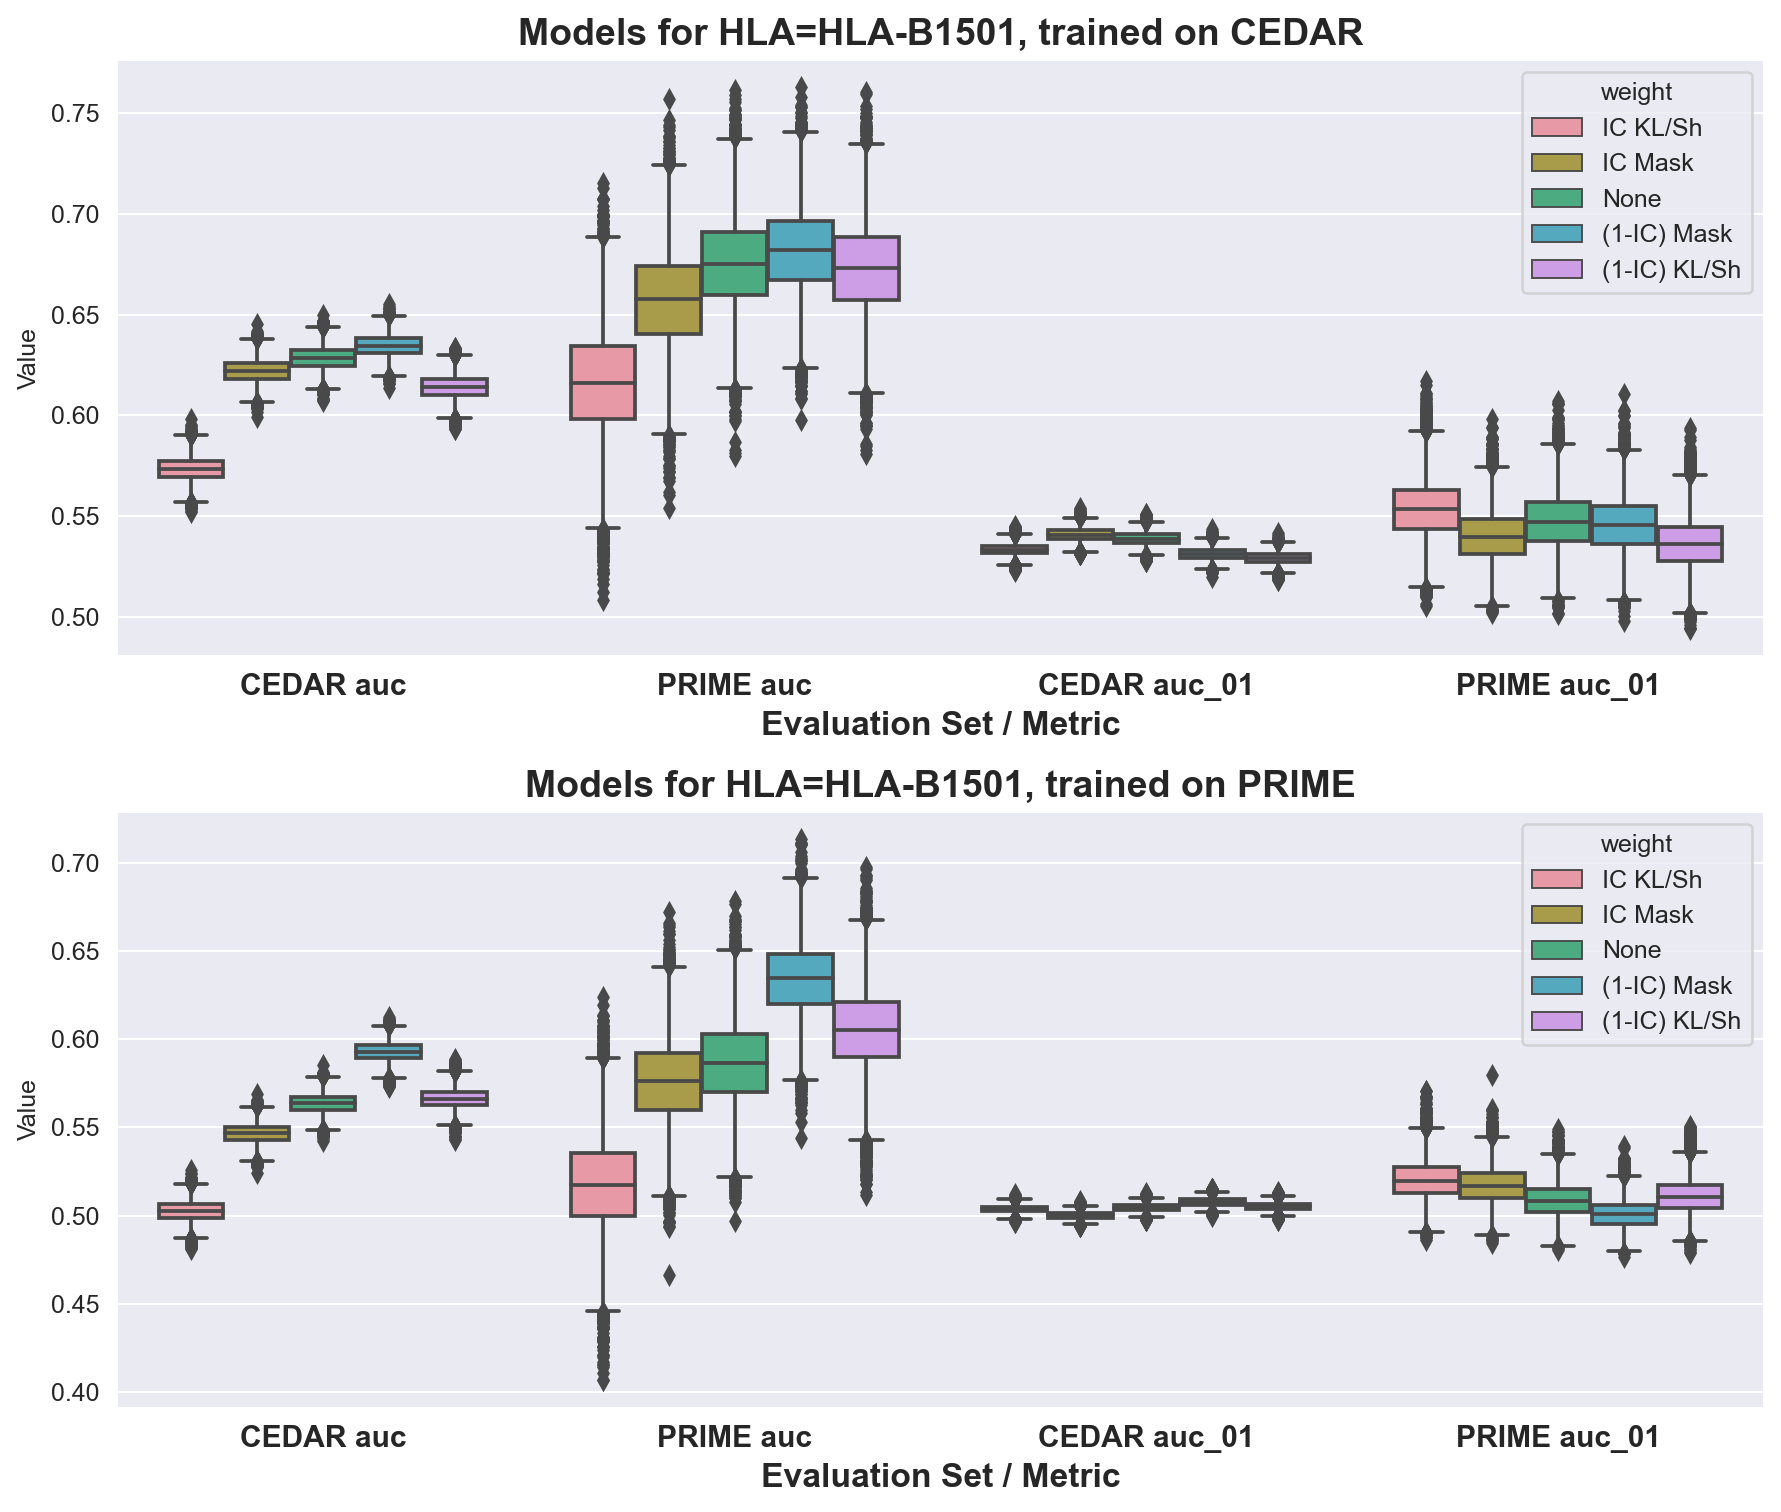

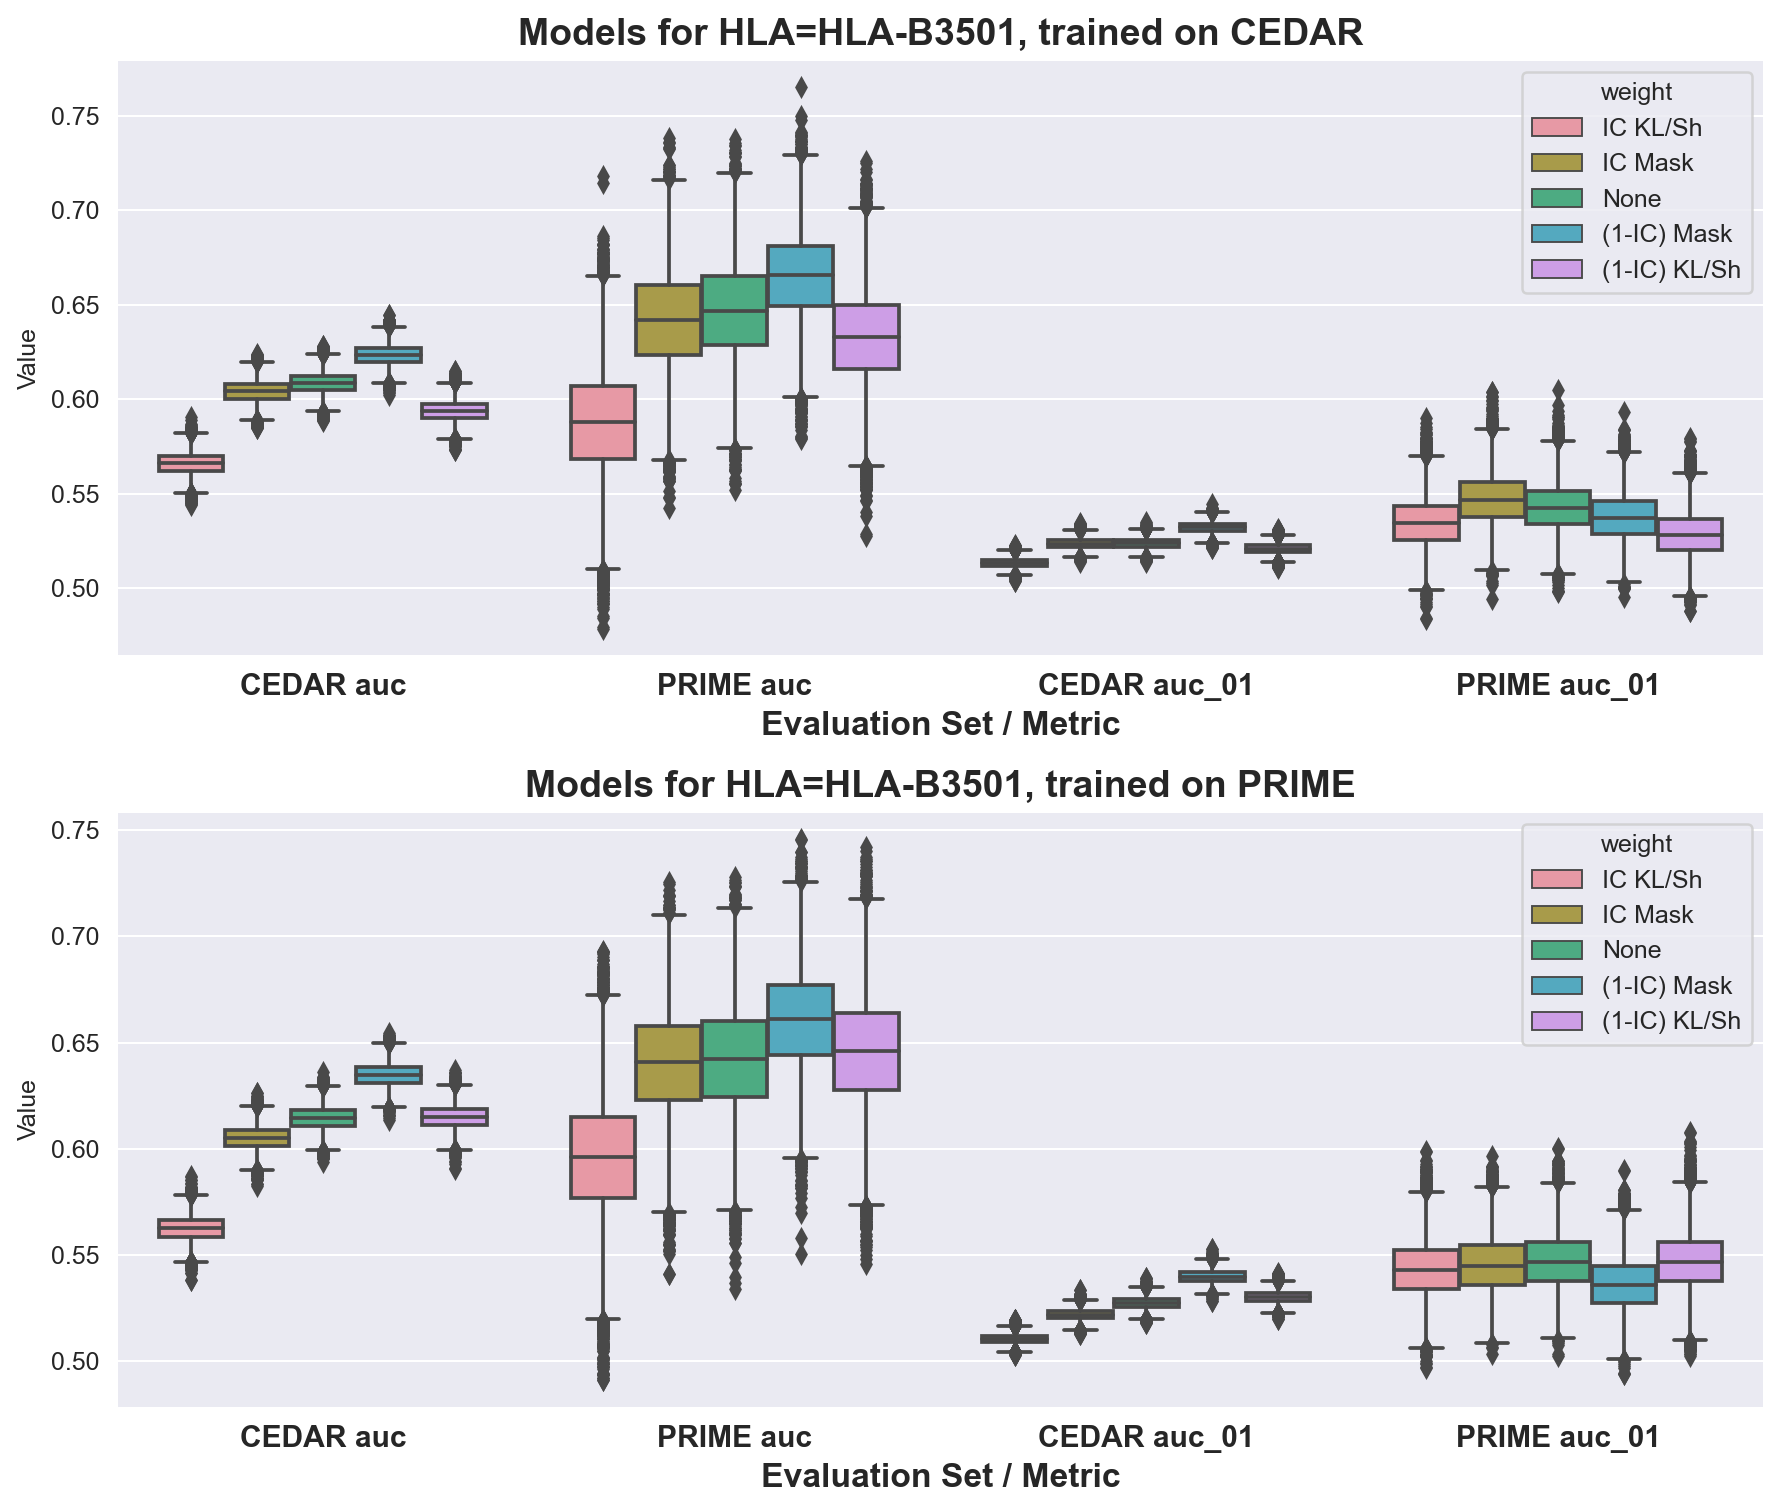

In [95]:
from sklearn.model_selection import StratifiedKFold
weight_order = ['IC KL/Sh', 'IC Mask', 'None', '(1-IC) Mask', '(1-IC) KL/Sh']
# For each HLA, do a subplot for each trainset
# Each subplot takes Weight as hue, and Evalset as X
dfx = pd.concat([df_hla, df_rest])
for hla in ['non_top']+list(df_hla.hla.unique()):
    if hla != 'non_top':
        # Just getting N per trainsets for a 5fold kcv
        n_pos_cedar = len(cedar_related.query('HLA==@hla and agg_label==1'))//5
        n_neg_cedar = len(cedar_related.query('HLA==@hla and agg_label==0'))//5
        n_pos_prime = len(prime_related.query('HLA==@hla and agg_label==1'))//5
        n_neg_prime = len(prime_related.query('HLA==@hla and agg_label==0'))//5
    else:
        top_hlas = df_hla.hla.unique()
        n_pos_cedar = len(cedar_related.query('HLA not in @top_hlas and agg_label==1'))//5
        n_neg_cedar = len(cedar_related.query('HLA not in @top_hlas and agg_label==0'))//5
        n_pos_prime = len(prime_related.query('HLA not in @top_hlas and agg_label==1'))//5
        n_neg_prime = len(prime_related.query('HLA not in @top_hlas and agg_label==0'))//5

    # Plotting for each trainset/subplot
    f,a = plt.subplots(2, 1, figsize=(10,8.5))
    for trainset, axis in zip(['CEDAR', 'PRIME'], a.ravel()):
        tmp_df = pd.melt(dfx.query('hla==@hla and trainset==@trainset').drop(columns = ['hla', 'trainset']),
                         id_vars = ['weight', 'evalset'], value_vars = ['auc', 'auc_01'])
        tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
        tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
        sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
        plt.setp(axis.collections, alpha=.75)
        axis.set_title(f'Models for HLA={hla}, trained on {trainset}', fontweight = 'semibold', fontsize = 15)
        axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12))
        axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
        axis.set_ylabel('Value')
    f.tight_layout()
    f.savefig(f'../output/hla_analysis/{hla}_models_boxplots.png', bbox_inches = 'tight', dpi = 200)

# Anti-top hla models

In [32]:
prime_related.query('HLA not in @top_hlas').groupby(['agg_label']).agg(count=('Peptide','count'))

,count
agg_label,
0,975
1,53


In [33]:
cedar_related.query('HLA not in @top_hlas').groupby(['agg_label']).agg(count=('Peptide','count'))

,count
agg_label,
0,545
1,209


In [39]:
# Making folds
from src.partition_tools import pipeline_stratified_kfold
prime_non_top = prime_related.query('HLA not in @top_hlas').sort_values('Peptide', ascending=True).reset_index(drop=True)
cedar_non_top = cedar_related.query('HLA not in @top_hlas').sort_values('Peptide', ascending=True).reset_index(drop=True)
prime_non_top.to_csv('../../kern_dist/data/221217_prime_non_top.pep', columns=['Peptide'], index=False, header=False)
cedar_non_top.to_csv('../../kern_dist/data/221217_cedar_non_top.pep', columns=['Peptide'], index=False, header=False)

In [42]:
prime_non_top_fold = pipeline_stratified_kfold('../../kern_dist/out/221217_prime_non_top.pep_0.9.out',
                                               prime_non_top, k=5, pep_col = 'Peptide', elrank_col = 'EL_rank_mut')
cedar_non_top_fold = pipeline_stratified_kfold('../../kern_dist/out/221217_cedar_non_top.pep_0.9.out',
                                               cedar_non_top, k=5, pep_col = 'Peptide', elrank_col = 'EL_rank_mut')


start 1028
read hobohm 833 200
strat kfold unique 833 200
manually reassign identical 833 200
manually reassign related 833 200
concat 1033
merge 1033
drop duplicated 1028
start 754
read hobohm 664 98
strat kfold unique 664 98
manually reassign identical 664 98
manually reassign related 664 98
concat 762
merge 762
drop duplicated 754


In [46]:
prime_non_top_fold.to_csv('../data/mutant/221217_prime_non_top_5fold.csv', index=False)
cedar_non_top_fold.to_csv('../data/mutant/221217_cedar_non_top_5fold.csv', index=False)